# Формирование обучающей и бенчмарк вборок из датасета BigP300BCI для дипломной работы

## 0. Конфиг

In [8]:
from pathlib import Path
import json

# ---- Paths ----
RAW_ROOT = Path(r"C:\data_bigp3bci\bigP3BCI-data")

DATA_ROOT = Path(r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\BigP300BCI")

OUT_ROOT = DATA_ROOT / "downstream"
TRAIN_ROOT = OUT_ROOT / "train"
BENCH_ROOT = OUT_ROOT / "benchmark"

TRAIN_ROOT.mkdir(parents=True, exist_ok=True)
BENCH_ROOT.mkdir(parents=True, exist_ok=True)

# ---- Study split ----

ALL_STUDIES = [
    "StudyA","StudyB","StudyC","StudyD","StudyE",
    "StudyF","StudyG","StudyH","StudyI","StudyJ",
    "StudyK","StudyL","StudyM","StudyN","StudyO",
    "StudyP","StudyQ","StudyR","StudyS1","StudyS2"
]
TRAIN_STUDIES = ["StudyA","StudyC","StudyE","StudyH","StudyL","StudyN","StudyO"]
BENCH_STUDIES = ["StudyD","StudyF","StudyG","StudyI","StudyK"]

# ---- EEG config (same as SSL) ----
TARGET_CHS = [
    "Fz","Cz","Pz","Oz","P3","P4","PO7","PO8",
    "F3","F4","C3","C4","CP3","CP4"
]

FS_TARGET = 256
FMIN = 0.1
FMAX = 20.0

EPOCH_TMIN = 0.0
EPOCH_TMAX = 0.8
L_FIXED = 208

print("CONFIG READY")

CONFIG READY


## 1.1. Индекс EDF (сделаем для всего датасета)

In [4]:
import pandas as pd

FULL_INDEX_PATH = DATA_ROOT / "records_index_full.csv"

records = []

for study in ALL_STUDIES:
    
    study_path = RAW_ROOT / study
    
    if not study_path.exists():
        print(f"⚠️ Study not found: {study_path}")
        continue
    
    edf_files = list(study_path.rglob("*.edf"))
    
    print(f"{study}: {len(edf_files)} EDF")
    
    for edf_path in edf_files:
        
        relpath = edf_path.relative_to(RAW_ROOT)
        parts = relpath.parts
        
        study_name = parts[0]
        subject = parts[1] if len(parts) > 1 else None
        session = parts[2] if len(parts) > 2 else None
        
        phase = None
        for p in parts:
            if p.lower() in ["train", "test"]:
                phase = p
        
        records.append({
            "study": study_name,
            "subject": subject,
            "session": session,
            "phase": phase,
            "relpath": str(relpath),
            "abspath": str(edf_path)
        })

df_full = pd.DataFrame(records)
df_full = df_full.sort_values(["study","subject","session","relpath"]).reset_index(drop=True)
df_full["edf_id"] = df_full.index

print("TOTAL EDF:", len(df_full))
display(df_full.head())

df_full.to_csv(FULL_INDEX_PATH, index=False)

print("FULL INDEX SAVED:", FULL_INDEX_PATH)

StudyA: 390 EDF
StudyB: 544 EDF
StudyC: 341 EDF
StudyD: 307 EDF
StudyE: 88 EDF
StudyF: 270 EDF
StudyG: 320 EDF
StudyH: 372 EDF
StudyI: 265 EDF
StudyJ: 502 EDF
StudyK: 128 EDF
StudyL: 330 EDF
StudyM: 420 EDF
StudyN: 160 EDF
StudyO: 347 EDF
StudyP: 228 EDF
StudyQ: 720 EDF
StudyR: 480 EDF
StudyS1: 120 EDF
StudyS2: 288 EDF
TOTAL EDF: 6620


study subject session phase  \
0  StudyA    A_01   SE001  Test   
1  StudyA    A_01   SE001  Test   
2  StudyA    A_01   SE001  Test   
3  StudyA    A_01   SE001  Test   
4  StudyA    A_01   SE001  Test   

                                             relpath  \
0  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test06...   
1  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test07...   
2  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test08...   
3  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test09...   
4  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test10...   

                                             abspath  edf_id  
0  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       0  
1  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       1  
2  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       2  
3  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       3  
4  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       4

FULL INDEX SAVED: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\records_index_full.csv


In [5]:
df_full.groupby("study").size()

study
StudyA     390
StudyB     544
StudyC     341
StudyD     307
StudyE      88
StudyF     270
StudyG     320
StudyH     372
StudyI     265
StudyJ     502
StudyK     128
StudyL     330
StudyM     420
StudyN     160
StudyO     347
StudyP     228
StudyQ     720
StudyR     480
StudyS1    120
StudyS2    288
dtype: int64

## 1.2. Encoding + stable_hash (master index)

In [6]:
import hashlib

def stable_hash(s: str) -> int:
    h = hashlib.md5(s.encode("utf-8")).hexdigest()
    return int(h[:8], 16)

# encoding
study2id = {s: i for i, s in enumerate(sorted(df_full.study.unique()))}
subject2id = {s: i for i, s in enumerate(sorted(df_full.subject.unique()))}
session2id = {s: i for i, s in enumerate(sorted(df_full.session.unique()))}

print("studies:", len(study2id))
print("subjects:", len(subject2id))
print("sessions:", len(session2id))

# apply
df_full["study_id"] = df_full.study.map(study2id)
df_full["subject_id"] = df_full.subject.map(subject2id)
df_full["session_id"] = df_full.session.map(session2id)
df_full["record_hash"] = df_full.relpath.apply(stable_hash)

# save
df_full.to_csv(FULL_INDEX_PATH, index=False)

display(df_full.head())

studies: 20
subjects: 327
sessions: 10


study subject session phase  \
0  StudyA    A_01   SE001  Test   
1  StudyA    A_01   SE001  Test   
2  StudyA    A_01   SE001  Test   
3  StudyA    A_01   SE001  Test   
4  StudyA    A_01   SE001  Test   

                                             relpath  \
0  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test06...   
1  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test07...   
2  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test08...   
3  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test09...   
4  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test10...   

                                             abspath  edf_id  study_id  \
0  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       0         0   
1  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       1         0   
2  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       2         0   
3  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       3         0   
4  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       4         0   

   subject_id  session_id  record_hash  
0           0           0   1696022466  
1           0           0   2334694248  
2           0           0   2355453023  
3           0           0    657495990  
4           0           0    496441221

In [7]:
df_full.record_hash.nunique(), len(df_full)

(6620, 6620)

## 2. Split records по Study

In [9]:
train_df = df_full[df_full.study.isin(TRAIN_STUDIES)].copy()
bench_df = df_full[df_full.study.isin(BENCH_STUDIES)].copy()

print("Train EDF:", len(train_df))
print("Benchmark EDF:", len(bench_df))

display(train_df.head())
display(bench_df.head())

Train EDF: 2028
Benchmark EDF: 1290


study subject session phase  \
0  StudyA    A_01   SE001  Test   
1  StudyA    A_01   SE001  Test   
2  StudyA    A_01   SE001  Test   
3  StudyA    A_01   SE001  Test   
4  StudyA    A_01   SE001  Test   

                                             relpath  \
0  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test06...   
1  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test07...   
2  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test08...   
3  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test09...   
4  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test10...   

                                             abspath  edf_id  study_id  \
0  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       0         0   
1  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       1         0   
2  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       2         0   
3  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       3         0   
4  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       4         0   

   subject_id  session_id  record_hash  
0           0           0   1696022466  
1           0           0   2334694248  
2           0           0   2355453023  
3           0           0    657495990  
4           0           0    496441221

study subject session phase  \
1275  StudyD    D_01   SE001  Test   
1276  StudyD    D_01   SE001  Test   
1277  StudyD    D_01   SE001  Test   
1278  StudyD    D_01   SE001  Test   
1279  StudyD    D_01   SE001  Test   

                                                relpath  \
1275  StudyD\D_01\SE001\Test\DynBigram\D_01_SE001_Dy...   
1276  StudyD\D_01\SE001\Test\DynBigram\D_01_SE001_Dy...   
1277  StudyD\D_01\SE001\Test\DynBigram\D_01_SE001_Dy...   
1278  StudyD\D_01\SE001\Test\DynBigram\D_01_SE001_Dy...   
1279  StudyD\D_01\SE001\Test\DynBigram\D_01_SE001_Dy...   

                                                abspath  edf_id  study_id  \
1275  C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE0...    1275         3   
1276  C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE0...    1276         3   
1277  C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE0...    1277         3   
1278  C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE0...    1278         3   
1279  C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE0...    1279         3   

      subject_id  session_id  record_hash  
1275          51           0   3712391300  
1276          51           0    398183940  
1277          51           0   2410748903  
1278          51           0   3679995257  
1279          51           0   2382834862

In [10]:
# Проверка
len(train_df) + len(bench_df)

3318

In [13]:
train_df.groupby("study").size()


study
StudyA    390
StudyC    341
StudyE     88
StudyH    372
StudyL    330
StudyN    160
StudyO    347
dtype: int64

In [12]:
bench_df.groupby("study").size()

study
StudyD    307
StudyF    270
StudyG    320
StudyI    265
StudyK    128
dtype: int64

In [14]:
train_df.subject.nunique(), bench_df.subject.nunique()

(93, 65)

## 3. Grouping по subject

In [16]:
train_subjects = {
    sid: g for sid, g in train_df.groupby("subject_id")
}

bench_subjects = {
    sid: g for sid, g in bench_df.groupby("subject_id")
}

print("Train subjects:", len(train_subjects))
print("Benchmark subjects:", len(bench_subjects))

# пример
example_sid = list(train_subjects.keys())[0]
display(train_subjects[example_sid].head())

Train subjects: 93
Benchmark subjects: 65


study subject session phase  \
0  StudyA    A_01   SE001  Test   
1  StudyA    A_01   SE001  Test   
2  StudyA    A_01   SE001  Test   
3  StudyA    A_01   SE001  Test   
4  StudyA    A_01   SE001  Test   

                                             relpath  \
0  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test06...   
1  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test07...   
2  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test08...   
3  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test09...   
4  StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test10...   

                                             abspath  edf_id  study_id  \
0  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       0         0   
1  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       1         0   
2  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       2         0   
3  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       3         0   
4  C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE0...       4         0   

   subject_id  session_id  record_hash  
0           0           0   1696022466  
1           0           0   2334694248  
2           0           0   2355453023  
3           0           0    657495990  
4           0           0    496441221

In [21]:
g = train_subjects[example_sid]

print("unique studies:", g.study.unique())
print("unique sessions:", g.session.unique())
print("unique session_id:", g.session_id.unique())

unique studies: ['StudyA']
unique sessions: ['SE001']
unique session_id: [0]


In [ ]:
# Добавим признак condition на всякий случай
def extract_condition(relpath):
    parts = Path(relpath).parts
    if len(parts) >= 5:
        return parts[4]
    return None

df_full["condition"] = df_full.relpath.apply(extract_condition)

df_full.to_csv(FULL_INDEX_PATH, index=False)

In [24]:
df_full.groupby("condition").size()

condition
AD                         64
ADdiff                    210
CB                       1506
CBCol                     200
CBERN                     284
CBGaze01                   81
CBGaze10                   78
CBGazeNo                   82
CBGazeReal                 80
CBP                       175
CrystalizeLarge           120
CrystalizeSmall           120
Dry                        80
Dyn                       162
DynBigram                 263
DynNgram                  100
EinsteinLarge             120
EinsteinSmall             120
Face                       60
Grey-to-Color             360
Grey-to-White             360
House                     204
NonpredictiveSpelling     114
PB                        384
PredictiveSpelling        114
RC                        593
RD                        130
SUP                       172
Static                     60
Tool                      144
Wet                        80
dtype: int64

## 4. Извлечение epochs 

In [25]:
import numpy as np
def save_subject_npz(out_path, X, y, edf_id, session_id, condition):
    np.savez_compressed(
        out_path,
        X=X.astype(np.float32),
        y=y.astype(np.uint8),
        edf_id=edf_id.astype(np.int32),
        session_id=session_id.astype(np.int16),
        condition=np.array(condition),
        fs=FS_TARGET,
        channels=np.array(TARGET_CHS),
        L_raw=int(round((EPOCH_TMAX-EPOCH_TMIN)*FS_TARGET)),
        L_pad=L_FIXED,
        event_order=np.arange(len(X))
    )

In [31]:
import mne
def load_record_events(edf_path):
    """
    Returns:
        onsets_samples : np.ndarray (n_events,)
        labels : np.ndarray (n_events,)
        sfreq : float
    """
    
    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
    
    sfreq = raw.info["sfreq"]
    
    # ---- find channels ----
    stim_begin_ch = [ch for ch in raw.ch_names if "StimulusBegin" in ch][0]
    stim_type_ch = [ch for ch in raw.ch_names if "StimulusType" in ch][0]
    
    stim_data = raw.copy().pick([stim_begin_ch, stim_type_ch]).get_data()
    
    stim_begin = stim_data[0]
    stim_type = stim_data[1]
    
    # ---- onsets ----
    stim_begin_bin = stim_begin > 0.5
    onsets = np.where(np.diff(stim_begin_bin.astype(int)) == 1)[0] + 1
    
    labels = stim_type[onsets].astype(int)
    
    return onsets, labels, sfreq

In [32]:
def prepare_raw_eeg(edf_path):
    """
    Load EDF and return prepared raw with 14 EEG channels
    """
    
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    
    # ---- find EEG channels ----
    eeg_map = {}
    
    for ch in raw.ch_names:
        if ch.startswith("EEG_"):
            name = ch.replace("EEG_", "")
            eeg_map[name] = ch
    
    # ---- check availability ----
    missing = [ch for ch in TARGET_CHS if ch not in eeg_map]
    
    if len(missing) > 0:
        raise RuntimeError(f"Missing channels: {missing}")
    
    # ---- pick + reorder ----
    picks = [eeg_map[ch] for ch in TARGET_CHS]
    raw_eeg = raw.copy().pick(picks)
    
    # rename to clean names
    raw_eeg.rename_channels({v: k for k, v in eeg_map.items() if k in TARGET_CHS})
    
    # reorder explicitly
    raw_eeg.reorder_channels(TARGET_CHS)
    
    # ---- resample ----
    raw_eeg.resample(FS_TARGET)
    
    # ---- filter ----
    raw_eeg.filter(FMIN, FMAX, verbose=False)
    
    return raw_eeg

In [33]:
def extract_epochs_array(raw_eeg, onsets_samples_orig, fs_orig):
    """
    raw_eeg: prepared raw (14 ch, fs_target, filtered)
    onsets_samples_orig: onsets in original EDF sampling
    fs_orig: original EDF sfreq
    
    Returns:
      X: (n, 14, L_FIXED) float32
      onsets_samples_resampled: (n,) int
    """
    fs_tgt = raw_eeg.info["sfreq"]
    
    # map onsets to resampled coordinate system
    onsets_rs = np.round(onsets_samples_orig * fs_tgt / fs_orig).astype(int)
    
    n = len(onsets_rs)
    n_ch = len(raw_eeg.ch_names)
    
    # number of samples to cut from signal for 0-0.8s
    L_cut = int(round((EPOCH_TMAX - EPOCH_TMIN) * fs_tgt))  # ~205
    
    X = np.zeros((n, n_ch, L_FIXED), dtype=np.float32)
    
    data = raw_eeg.get_data()  # (14, T)
    T = data.shape[1]
    
    for i, t0 in enumerate(onsets_rs):
        start = t0 + int(round(EPOCH_TMIN * fs_tgt))
        end = start + L_cut
        
        # boundary check
        if start < 0 or end > T:
            # пропускаем (не должно часто случаться, но пусть будет безопасно)
            continue
        
        epoch = data[:, start:end]  # (14, L_cut)
        
        # pad/trim to L_FIXED
        L = epoch.shape[1]
        if L >= L_FIXED:
            X[i] = epoch[:, :L_FIXED]
        else:
            X[i, :, :L] = epoch
    
    return X, onsets_rs

In [34]:
def build_subject_dataset(subject_df, out_root):
    
    sid = int(subject_df.subject_id.iloc[0])
    subj_name = subject_df.subject.iloc[0]
    
    X_all = []
    y_all = []
    edf_all = []
    session_all = []
    cond_all = []
    
    for _, row in subject_df.iterrows():
        
        edf_path = Path(row.abspath)
        
        try:
            # events
            onsets, labels, fs_orig = load_record_events(edf_path)
            if len(onsets) == 0:
                continue
            
            # EEG
            raw_eeg = prepare_raw_eeg(edf_path)
            
            # epochs
            X, onsets_rs = extract_epochs_array(raw_eeg, onsets, fs_orig)
            
            mask = ~np.all(X == 0, axis=(1,2))
            X = X[mask]
            labels = labels[mask]
            
            if len(X) == 0:
                continue
            
            # accumulate
            X_all.append(X)
            y_all.append(labels)
            edf_all.append(np.full(len(X), row.edf_id))
            session_all.append(np.full(len(X), row.session_id))
            cond_all.extend([row.condition]*len(X))
        
        except Exception as e:
            print("ERROR:", edf_path, e)
    
    if len(X_all) == 0:
        return
    
    X_all = np.concatenate(X_all)
    y_all = np.concatenate(y_all)
    edf_all = np.concatenate(edf_all)
    session_all = np.concatenate(session_all)
    
    out_path = out_root / f"subj_{sid:03d}.npz"
    
    save_subject_npz(out_path, X_all, y_all, edf_all, session_all, cond_all)
    
    print(subj_name, "→", X_all.shape)

### Сборка всех субъектов для Train

In [35]:
from tqdm.auto import tqdm

for sid, g in tqdm(train_subjects.items()):
    build_subject_dataset(g, TRAIN_ROOT)

  0%|          | 0/93 [00:00<?, ?it/s]

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\CB\A_01_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\RC\A_01_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\RC\A_01_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\RC\A_01_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\RC\A_01_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\RC\A_01_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\RD\A_01_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\RD\A_01_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\RD\A_01_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\RD\A_01_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Test\RD\A_01_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\CB\A_01_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\CB\A_01_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\CB\A_01_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\CB\A_01_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\CB\A_01_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\RC\A_01_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\RC\A_01_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\RC\A_01_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\RC\A_01_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\RC\A_01_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\RD\A_01_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\RD\A_01_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\RD\A_01_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\RD\A_01_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_01\SE001\Train\RD\A_01_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'
A_01 → (25848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\CB\A_02_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\CB\A_02_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\CB\A_02_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\CB\A_02_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\CB\A_02_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\RC\A_02_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\RC\A_02_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\RC\A_02_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\RC\A_02_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\RC\A_02_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\RD\A_02_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\RD\A_02_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\RD\A_02_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\RD\A_02_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Test\RD\A_02_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\CB\A_02_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\CB\A_02_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\CB\A_02_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\CB\A_02_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\CB\A_02_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\RC\A_02_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\RC\A_02_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\RC\A_02_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\RC\A_02_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\RC\A_02_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\RD\A_02_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\RD\A_02_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\RD\A_02_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\RD\A_02_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_02\SE001\Train\RD\A_02_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'
A_02 → (25848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\CB\A_03_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\CB\A_03_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\CB\A_03_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\CB\A_03_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\CB\A_03_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\RC\A_03_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\RC\A_03_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\RC\A_03_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\RC\A_03_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\RC\A_03_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\RD\A_03_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\RD\A_03_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\RD\A_03_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\RD\A_03_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Test\RD\A_03_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\CB\A_03_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\CB\A_03_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\CB\A_03_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\CB\A_03_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\CB\A_03_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\RC\A_03_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\RC\A_03_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\RC\A_03_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\RC\A_03_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\RC\A_03_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\RD\A_03_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\RD\A_03_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\RD\A_03_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\RD\A_03_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_03\SE001\Train\RD\A_03_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'
A_03 → (25848, 14, 208)


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\CB\A_04_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\CB\A_04_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\CB\A_04_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\CB\A_04_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\CB\A_04_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\RC\A_04_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\RC\A_04_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\RC\A_04_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\RC\A_04_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\RC\A_04_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\RD\A_04_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\RD\A_04_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\RD\A_04_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\RD\A_04_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Test\RD\A_04_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\CB\A_04_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\CB\A_04_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\CB\A_04_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\CB\A_04_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\CB\A_04_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\RC\A_04_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\RC\A_04_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\RC\A_04_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\RC\A_04_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\RC\A_04_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\RD\A_04_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\RD\A_04_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\RD\A_04_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\RD\A_04_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_04\SE001\Train\RD\A_04_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'
A_04 → (25848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\CB\A_05_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\CB\A_05_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\CB\A_05_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\CB\A_05_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\CB\A_05_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\RC\A_05_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\RC\A_05_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\RC\A_05_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\RC\A_05_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\RC\A_05_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\RD\A_05_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\RD\A_05_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\RD\A_05_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\RD\A_05_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Test\RD\A_05_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\CB\A_05_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\CB\A_05_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\CB\A_05_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\CB\A_05_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\CB\A_05_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\RC\A_05_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\RC\A_05_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\RC\A_05_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\RC\A_05_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\RC\A_05_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\RD\A_05_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\RD\A_05_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\RD\A_05_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\RD\A_05_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_05\SE001\Train\RD\A_05_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'
A_05 → (25848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\CB\A_06_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\CB\A_06_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\CB\A_06_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\CB\A_06_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\CB\A_06_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\RC\A_06_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\RC\A_06_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\RC\A_06_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\RC\A_06_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\RC\A_06_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\RD\A_06_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\RD\A_06_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\RD\A_06_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\RD\A_06_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Test\RD\A_06_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\CB\A_06_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\CB\A_06_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\CB\A_06_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\CB\A_06_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\CB\A_06_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\RC\A_06_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\RC\A_06_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\RC\A_06_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\RC\A_06_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\RC\A_06_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\RD\A_06_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\RD\A_06_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\RD\A_06_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\RD\A_06_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_06\SE001\Train\RD\A_06_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'
A_06 → (25848, 14, 208)


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\CB\A_07_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\CB\A_07_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\CB\A_07_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\CB\A_07_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\CB\A_07_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\RC\A_07_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\RC\A_07_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\RC\A_07_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\RC\A_07_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\RC\A_07_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\RD\A_07_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\RD\A_07_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\RD\A_07_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\RD\A_07_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Test\RD\A_07_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\CB\A_07_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\CB\A_07_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\CB\A_07_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\CB\A_07_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\CB\A_07_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\RC\A_07_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\RC\A_07_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\RC\A_07_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\RC\A_07_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\RC\A_07_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\RD\A_07_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\RD\A_07_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\RD\A_07_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\RD\A_07_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_07\SE001\Train\RD\A_07_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'
A_07 → (25848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\CB\A_09_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\CB\A_09_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\CB\A_09_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\CB\A_09_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\CB\A_09_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\RC\A_09_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\RC\A_09_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\RC\A_09_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\RC\A_09_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\RC\A_09_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\RD\A_09_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\RD\A_09_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\RD\A_09_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\RD\A_09_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Test\RD\A_09_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\CB\A_09_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\CB\A_09_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\CB\A_09_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\CB\A_09_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\CB\A_09_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\RC\A_09_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\RC\A_09_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\RC\A_09_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\RC\A_09_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\RC\A_09_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\RD\A_09_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\RD\A_09_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\RD\A_09_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\RD\A_09_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_09\SE001\Train\RD\A_09_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'
A_09 → (25848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\CB\A_14_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\CB\A_14_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\CB\A_14_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\CB\A_14_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\CB\A_14_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\RC\A_14_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\RC\A_14_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\RC\A_14_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\RC\A_14_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\RC\A_14_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\RD\A_14_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\RD\A_14_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\RD\A_14_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\RD\A_14_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Test\RD\A_14_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\CB\A_14_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\CB\A_14_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\CB\A_14_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\CB\A_14_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\CB\A_14_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\RC\A_14_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\RC\A_14_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\RC\A_14_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\RC\A_14_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\RC\A_14_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\RD\A_14_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\RD\A_14_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\RD\A_14_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\RD\A_14_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_14\SE001\Train\RD\A_14_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


A_14 → (25848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\CB\A_15_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\CB\A_15_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\CB\A_15_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\CB\A_15_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\CB\A_15_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\RC\A_15_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\RC\A_15_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\RC\A_15_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\RC\A_15_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\RC\A_15_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\RD\A_15_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\RD\A_15_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\RD\A_15_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\RD\A_15_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Test\RD\A_15_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\CB\A_15_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\CB\A_15_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\CB\A_15_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\CB\A_15_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\CB\A_15_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\RC\A_15_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\RC\A_15_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\RC\A_15_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\RC\A_15_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\RC\A_15_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\RD\A_15_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\RD\A_15_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\RD\A_15_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\RD\A_15_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_15\SE001\Train\RD\A_15_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


A_15 → (25848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\CB\A_16_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\CB\A_16_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\CB\A_16_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\CB\A_16_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\CB\A_16_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\RC\A_16_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\RC\A_16_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\RC\A_16_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

 C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\RC\A_16_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\RC\A_16_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\RD\A_16_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\RD\A_16_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\RD\A_16_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\RD\A_16_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Test\RD\A_16_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\CB\A_16_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\CB\A_16_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\CB\A_16_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\CB\A_16_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\CB\A_16_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\RC\A_16_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\RC\A_16_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\RC\A_16_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\RC\A_16_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\RC\A_16_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\RD\A_16_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\RD\A_16_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\RD\A_16_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\RD\A_16_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_16\SE001\Train\RD\A_16_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


A_16 → (25848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\CB\A_17_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\CB\A_17_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\CB\A_17_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\CB\A_17_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\CB\A_17_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\RC\A_17_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\RC\A_17_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\RC\A_17_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\RC\A_17_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\RC\A_17_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\RD\A_17_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\RD\A_17_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\RD\A_17_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\RD\A_17_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Test\RD\A_17_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\CB\A_17_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\CB\A_17_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\CB\A_17_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\CB\A_17_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\CB\A_17_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\RC\A_17_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\RC\A_17_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\RC\A_17_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\RC\A_17_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\RC\A_17_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\RD\A_17_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\RD\A_17_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\RD\A_17_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\RD\A_17_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_17\SE001\Train\RD\A_17_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


A_17 → (25848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\CB\A_19_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\CB\A_19_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\CB\A_19_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\CB\A_19_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\CB\A_19_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\RC\A_19_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\RC\A_19_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\RC\A_19_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\RC\A_19_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\RC\A_19_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\RD\A_19_SE001_RD_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\RD\A_19_SE001_RD_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\RD\A_19_SE001_RD_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\RD\A_19_SE001_RD_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Test\RD\A_19_SE001_RD_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\CB\A_19_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\CB\A_19_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\CB\A_19_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\CB\A_19_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\CB\A_19_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\RC\A_19_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\RC\A_19_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\RC\A_19_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\RC\A_19_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\RC\A_19_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\RD\A_19_SE001_RD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\RD\A_19_SE001_RD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\RD\A_19_SE001_RD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\RD\A_19_SE001_RD_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyA\A_19\SE001\Train\RD\A_19_SE001_RD_Train05.edf 'Series' object has no attribute 'condition'
A_19 → (25848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Test\CBERN\C_01_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Train\CB\C_01_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Train\CB\C_01_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Train\CB\C_01_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_01\SE001\Train\CB\C_01_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_01 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Test\CBERN\C_02_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Train\CB\C_02_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Train\CB\C_02_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Train\CB\C_02_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_02\SE001\Train\CB\C_02_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_02 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Test\CBERN\C_03_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Train\CB\C_03_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Train\CB\C_03_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Train\CB\C_03_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_03\SE001\Train\CB\C_03_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_03 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Test\CBERN\C_04_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Train\CB\C_04_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Train\CB\C_04_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Train\CB\C_04_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_04\SE001\Train\CB\C_04_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_04 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Test\CBERN\C_06_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Train\CB\C_06_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Train\CB\C_06_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Train\CB\C_06_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_06\SE001\Train\CB\C_06_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_06 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Test\CBERN\C_07_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Train\CB\C_07_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Train\CB\C_07_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Train\CB\C_07_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_07\SE001\Train\CB\C_07_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_07 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


 C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Test\CBERN\C_08_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Train\CB\C_08_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Train\CB\C_08_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Train\CB\C_08_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_08\SE001\Train\CB\C_08_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_08 → (9120, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Test\CBERN\C_09_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Train\CB\C_09_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Train\CB\C_09_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Train\CB\C_09_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_09\SE001\Train\CB\C_09_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_09 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Test\CBERN\C_10_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Train\CB\C_10_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Train\CB\C_10_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Train\CB\C_10_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_10\SE001\Train\CB\C_10_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_10 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Test\CBERN\C_11_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Train\CB\C_11_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Train\CB\C_11_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Train\CB\C_11_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_11\SE001\Train\CB\C_11_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_11 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Test\CBERN\C_12_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Train\CB\C_12_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Train\CB\C_12_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Train\CB\C_12_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_12\SE001\Train\CB\C_12_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_12 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Test\CBERN\C_13_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Train\CB\C_13_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Train\CB\C_13_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Train\CB\C_13_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_13\SE001\Train\CB\C_13_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
C_13 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


 C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Test\CBERN\C_14_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Train\CB\C_14_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Train\CB\C_14_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Train\CB\C_14_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_14\SE001\Train\CB\C_14_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
C_14 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Test\CBERN\C_15_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Train\CB\C_15_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Train\CB\C_15_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Train\CB\C_15_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_15\SE001\Train\CB\C_15_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


C_15 → (9600, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Test\CBERN\C_17_SE001_CBERN_Test20.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_17\SE001\Train\CB\C_17_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
C_17 → (7800, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_18\SE001\Test\CBERN\C_18_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
C_18 → (7200, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_20\SE001\Test\CBERN\C_20_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
C_20 → (7200, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_21\SE001\Test\CBERN\C_21_SE001_CBERN_Test20.edf 'Series' object has no attribute 'condition'
C_21 → (7200, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test16.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test17.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test18.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyC\C_22\SE001\Test\CBERN\C_22_SE001_CBERN_Test19.edf 'Series' object has no attribute 'condition'
C_22 → (7200, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_01\SE001\Test\CB\E_01_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_01\SE001\Test\CB\E_01_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_01\SE001\Test\CB\E_01_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_01\SE001\Test\CB\E_01_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_01\SE001\Test\CB\E_01_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_01\SE001\Train\CB\E_01_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_01\SE001\Train\CB\E_01_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_01\SE001\Train\CB\E_01_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_01\SE001\Train\CB\E_01_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_01\SE001\Train\CB\E_01_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_01\SE001\Train\CB\E_01_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
E_01 → (6276, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_02\SE001\Test\CB\E_02_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_02\SE001\Test\CB\E_02_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_02\SE001\Test\CB\E_02_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_02\SE001\Test\CB\E_02_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_02\SE001\Test\CB\E_02_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_02\SE001\Train\CB\E_02_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_02\SE001\Train\CB\E_02_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_02\SE001\Train\CB\E_02_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_02\SE001\Train\CB\E_02_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_02\SE001\Train\CB\E_02_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_02\SE001\Train\CB\E_02_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
E_02 → (6698, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_03\SE001\Test\CB\E_03_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_03\SE001\Test\CB\E_03_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_03\SE001\Test\CB\E_03_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_03\SE001\Test\CB\E_03_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_03\SE001\Test\CB\E_03_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_03\SE001\Train\CB\E_03_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_03\SE001\Train\CB\E_03_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_03\SE001\Train\CB\E_03_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_03\SE001\Train\CB\E_03_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_03\SE001\Train\CB\E_03_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_03\SE001\Train\CB\E_03_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
E_03 → (5581, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_04\SE001\Test\CB\E_04_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_04\SE001\Test\CB\E_04_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_04\SE001\Test\CB\E_04_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_04\SE001\Test\CB\E_04_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_04\SE001\Test\CB\E_04_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_04\SE001\Train\CB\E_04_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_04\SE001\Train\CB\E_04_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_04\SE001\Train\CB\E_04_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_04\SE001\Train\CB\E_04_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

 C:\data_bigp3bci\bigP3BCI-data\StudyE\E_04\SE001\Train\CB\E_04_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_04\SE001\Train\CB\E_04_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


E_04 → (6185, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_05\SE001\Test\CB\E_05_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_05\SE001\Test\CB\E_05_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_05\SE001\Test\CB\E_05_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_05\SE001\Test\CB\E_05_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_05\SE001\Test\CB\E_05_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_05\SE001\Train\CB\E_05_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_05\SE001\Train\CB\E_05_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_05\SE001\Train\CB\E_05_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_05\SE001\Train\CB\E_05_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_05\SE001\Train\CB\E_05_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_05\SE001\Train\CB\E_05_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
E_05 → (5286, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_06\SE001\Test\CB\E_06_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_06\SE001\Test\CB\E_06_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_06\SE001\Test\CB\E_06_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_06\SE001\Test\CB\E_06_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_06\SE001\Test\CB\E_06_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_06\SE001\Train\CB\E_06_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_06\SE001\Train\CB\E_06_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_06\SE001\Train\CB\E_06_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_06\SE001\Train\CB\E_06_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_06\SE001\Train\CB\E_06_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_06\SE001\Train\CB\E_06_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
E_06 → (6086, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_07\SE001\Test\CB\E_07_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_07\SE001\Test\CB\E_07_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_07\SE001\Test\CB\E_07_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_07\SE001\Test\CB\E_07_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_07\SE001\Test\CB\E_07_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_07\SE001\Train\CB\E_07_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_07\SE001\Train\CB\E_07_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_07\SE001\Train\CB\E_07_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_07\SE001\Train\CB\E_07_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_07\SE001\Train\CB\E_07_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_07\SE001\Train\CB\E_07_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
E_07 → (5091, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_08\SE001\Test\CB\E_08_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_08\SE001\Test\CB\E_08_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_08\SE001\Test\CB\E_08_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_08\SE001\Test\CB\E_08_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_08\SE001\Test\CB\E_08_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_08\SE001\Train\CB\E_08_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_08\SE001\Train\CB\E_08_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_08\SE001\Train\CB\E_08_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


 C:\data_bigp3bci\bigP3BCI-data\StudyE\E_08\SE001\Train\CB\E_08_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_08\SE001\Train\CB\E_08_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyE\E_08\SE001\Train\CB\E_08_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
E_08 → (7193, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGaze01\H_01_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGaze01\H_01_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGaze01\H_01_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGaze01\H_01_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGaze01\H_01_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGaze01\H_01_SE001_CBGaze01_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGaze10\H_01_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGaze10\H_01_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGaze10\H_01_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGazeNo\H_01_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGazeNo\H_01_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGazeNo\H_01_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGazeNo\H_01_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGazeNo\H_01_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGazeNo\H_01_SE001_CBGazeNo_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGazeReal\H_01_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGazeReal\H_01_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGazeReal\H_01_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGazeReal\H_01_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Test\CBGazeReal\H_01_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Train\CB\H_01_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Train\CB\H_01_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_01\SE001\Train\CB\H_01_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_01 → (9130, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGaze01\H_02_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGaze01\H_02_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGaze01\H_02_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGaze01\H_02_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGaze01\H_02_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGaze10\H_02_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGaze10\H_02_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGaze10\H_02_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGaze10\H_02_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGaze10\H_02_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGazeNo\H_02_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGazeNo\H_02_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGazeNo\H_02_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGazeNo\H_02_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGazeNo\H_02_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGazeReal\H_02_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGazeReal\H_02_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGazeReal\H_02_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGazeReal\H_02_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Test\CBGazeReal\H_02_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Train\CB\H_02_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Train\CB\H_02_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_02\SE001\Train\CB\H_02_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_02 → (7592, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGaze01\H_03_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGaze01\H_03_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGaze01\H_03_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGaze01\H_03_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGaze01\H_03_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGaze10\H_03_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGaze10\H_03_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGaze10\H_03_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGaze10\H_03_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGaze10\H_03_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGazeNo\H_03_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGazeNo\H_03_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGazeNo\H_03_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGazeNo\H_03_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGazeNo\H_03_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGazeReal\H_03_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGazeReal\H_03_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGazeReal\H_03_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGazeReal\H_03_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Test\CBGazeReal\H_03_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Train\CB\H_03_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Train\CB\H_03_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_03\SE001\Train\CB\H_03_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_03 → (10543, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGaze01\H_04_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGaze01\H_04_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGaze01\H_04_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGaze01\H_04_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGaze01\H_04_SE001_CBGaze01_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGaze10\H_04_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGaze10\H_04_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGaze10\H_04_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGaze10\H_04_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGaze10\H_04_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

 C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGazeNo\H_04_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGazeNo\H_04_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGazeNo\H_04_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGazeNo\H_04_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGazeNo\H_04_SE001_CBGazeNo_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGazeReal\H_04_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGazeReal\H_04_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGazeReal\H_04_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGazeReal\H_04_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Test\CBGazeReal\H_04_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Train\CB\H_04_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Train\CB\H_04_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_04\SE001\Train\CB\H_04_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_04 → (8247, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGaze01\H_05_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGaze01\H_05_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGaze01\H_05_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGaze01\H_05_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGaze01\H_05_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGaze10\H_05_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGaze10\H_05_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGaze10\H_05_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGaze10\H_05_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGaze10\H_05_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGazeNo\H_05_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGazeNo\H_05_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGazeNo\H_05_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGazeNo\H_05_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGazeNo\H_05_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGazeReal\H_05_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGazeReal\H_05_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGazeReal\H_05_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGazeReal\H_05_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Test\CBGazeReal\H_05_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Train\CB\H_05_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Train\CB\H_05_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_05\SE001\Train\CB\H_05_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_05 → (7271, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGaze01\H_06_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGaze01\H_06_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGaze01\H_06_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGaze01\H_06_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGaze01\H_06_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGaze10\H_06_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGaze10\H_06_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGaze10\H_06_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGaze10\H_06_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGaze10\H_06_SE001_CBGaze10_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGazeNo\H_06_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGazeNo\H_06_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGazeNo\H_06_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGazeNo\H_06_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGazeNo\H_06_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGazeReal\H_06_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGazeReal\H_06_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGazeReal\H_06_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGazeReal\H_06_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Test\CBGazeReal\H_06_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Train\CB\H_06_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Train\CB\H_06_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_06\SE001\Train\CB\H_06_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_06 → (9285, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGaze01\H_07_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGaze01\H_07_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGaze01\H_07_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGaze01\H_07_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGaze01\H_07_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGaze10\H_07_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGaze10\H_07_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGaze10\H_07_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGaze10\H_07_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGaze10\H_07_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGazeNo\H_07_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGazeNo\H_07_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGazeNo\H_07_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGazeNo\H_07_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGazeNo\H_07_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGazeReal\H_07_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGazeReal\H_07_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGazeReal\H_07_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGazeReal\H_07_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Test\CBGazeReal\H_07_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Train\CB\H_07_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Train\CB\H_07_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_07\SE001\Train\CB\H_07_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_07 → (6301, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGaze01\H_08_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGaze01\H_08_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGaze01\H_08_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGaze01\H_08_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGaze01\H_08_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGaze10\H_08_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGaze10\H_08_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGaze10\H_08_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGaze10\H_08_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGaze10\H_08_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGazeNo\H_08_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGazeNo\H_08_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGazeNo\H_08_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGazeNo\H_08_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGazeNo\H_08_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGazeNo\H_08_SE001_CBGazeNo_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGazeReal\H_08_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGazeReal\H_08_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGazeReal\H_08_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGazeReal\H_08_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Test\CBGazeReal\H_08_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Train\CB\H_08_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Train\CB\H_08_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Train\CB\H_08_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Train\CB\H_08_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Train\CB\H_08_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_08\SE001\Train\CB\H_08_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
H_08 → (9224, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGaze01\H_09_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGaze01\H_09_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGaze01\H_09_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGaze01\H_09_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGaze01\H_09_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGaze10\H_09_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGaze10\H_09_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGaze10\H_09_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGaze10\H_09_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGaze10\H_09_SE001_CBGaze10_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGazeNo\H_09_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGazeNo\H_09_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGazeNo\H_09_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGazeNo\H_09_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGazeNo\H_09_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGazeReal\H_09_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGazeReal\H_09_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGazeReal\H_09_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGazeReal\H_09_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Test\CBGazeReal\H_09_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Train\CB\H_09_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Train\CB\H_09_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_09\SE001\Train\CB\H_09_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_09 → (7365, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGaze01\H_10_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGaze01\H_10_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGaze01\H_10_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGaze01\H_10_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGaze01\H_10_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGaze10\H_10_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGaze10\H_10_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGaze10\H_10_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGaze10\H_10_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGaze10\H_10_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGazeNo\H_10_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGazeNo\H_10_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGazeNo\H_10_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGazeNo\H_10_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGazeNo\H_10_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGazeReal\H_10_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGazeReal\H_10_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGazeReal\H_10_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGazeReal\H_10_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Test\CBGazeReal\H_10_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Train\CB\H_10_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Train\CB\H_10_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_10\SE001\Train\CB\H_10_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_10 → (5609, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGaze01\H_11_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGaze01\H_11_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGaze01\H_11_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGaze01\H_11_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGaze01\H_11_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGaze10\H_11_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGaze10\H_11_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGaze10\H_11_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGaze10\H_11_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGaze10\H_11_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGazeNo\H_11_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGazeNo\H_11_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGazeNo\H_11_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGazeNo\H_11_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGazeNo\H_11_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGazeReal\H_11_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGazeReal\H_11_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGazeReal\H_11_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGazeReal\H_11_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Test\CBGazeReal\H_11_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Train\CB\H_11_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Train\CB\H_11_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_11\SE001\Train\CB\H_11_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_11 → (5637, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGaze01\H_12_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGaze01\H_12_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGaze01\H_12_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGaze01\H_12_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGaze01\H_12_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGaze10\H_12_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGaze10\H_12_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGaze10\H_12_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGaze10\H_12_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGaze10\H_12_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGazeNo\H_12_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGazeNo\H_12_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGazeNo\H_12_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGazeNo\H_12_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGazeNo\H_12_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGazeReal\H_12_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGazeReal\H_12_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGazeReal\H_12_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGazeReal\H_12_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Test\CBGazeReal\H_12_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Train\CB\H_12_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Train\CB\H_12_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_12\SE001\Train\CB\H_12_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_12 → (8576, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGaze01\H_13_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGaze01\H_13_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGaze01\H_13_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGaze01\H_13_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGaze01\H_13_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGaze10\H_13_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGaze10\H_13_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGaze10\H_13_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGaze10\H_13_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGaze10\H_13_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGazeNo\H_13_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGazeNo\H_13_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGazeNo\H_13_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGazeNo\H_13_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGazeNo\H_13_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGazeReal\H_13_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGazeReal\H_13_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGazeReal\H_13_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGazeReal\H_13_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Test\CBGazeReal\H_13_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Train\CB\H_13_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Train\CB\H_13_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_13\SE001\Train\CB\H_13_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_13 → (8224, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGaze01\H_14_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGaze01\H_14_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGaze01\H_14_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGaze01\H_14_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGaze01\H_14_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGaze10\H_14_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGaze10\H_14_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGaze10\H_14_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGaze10\H_14_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGaze10\H_14_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGazeNo\H_14_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGazeNo\H_14_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGazeNo\H_14_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGazeNo\H_14_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGazeNo\H_14_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGazeReal\H_14_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGazeReal\H_14_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGazeReal\H_14_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGazeReal\H_14_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Test\CBGazeReal\H_14_SE001_CBGazeReal_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Train\CB\H_14_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Train\CB\H_14_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_14\SE001\Train\CB\H_14_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_14 → (6856, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGaze01\H_15_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGaze01\H_15_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGaze01\H_15_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGaze01\H_15_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGaze01\H_15_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGaze10\H_15_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGaze10\H_15_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGaze10\H_15_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGaze10\H_15_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGaze10\H_15_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGazeNo\H_15_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGazeNo\H_15_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGazeNo\H_15_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGazeNo\H_15_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGazeNo\H_15_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGazeReal\H_15_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGazeReal\H_15_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGazeReal\H_15_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGazeReal\H_15_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Test\CBGazeReal\H_15_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Train\CB\H_15_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Train\CB\H_15_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_15\SE001\Train\CB\H_15_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_15 → (8681, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGaze01\H_16_SE001_CBGaze01_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGaze01\H_16_SE001_CBGaze01_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGaze01\H_16_SE001_CBGaze01_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGaze01\H_16_SE001_CBGaze01_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGaze01\H_16_SE001_CBGaze01_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGaze10\H_16_SE001_CBGaze10_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGaze10\H_16_SE001_CBGaze10_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGaze10\H_16_SE001_CBGaze10_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGaze10\H_16_SE001_CBGaze10_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGaze10\H_16_SE001_CBGaze10_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGazeNo\H_16_SE001_CBGazeNo_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

 C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGazeNo\H_16_SE001_CBGazeNo_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGazeNo\H_16_SE001_CBGazeNo_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGazeNo\H_16_SE001_CBGazeNo_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGazeNo\H_16_SE001_CBGazeNo_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGazeReal\H_16_SE001_CBGazeReal_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGazeReal\H_16_SE001_CBGazeReal_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGazeReal\H_16_SE001_CBGazeReal_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGazeReal\H_16_SE001_CBGazeReal_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Test\CBGazeReal\H_16_SE001_CBGazeReal_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Train\CB\H_16_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Train\CB\H_16_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyH\H_16\SE001\Train\CB\H_16_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
H_16 → (9099, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\CBCol\L_01_SE001_CBCol_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\CBCol\L_01_SE001_CBCol_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\CBCol\L_01_SE001_CBCol_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\CBCol\L_01_SE001_CBCol_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\CBCol\L_01_SE001_CBCol_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\CB\L_01_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\CB\L_01_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\CB\L_01_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\CB\L_01_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\CB\L_01_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\RC\L_01_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\RC\L_01_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\RC\L_01_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\RC\L_01_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Test\RC\L_01_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\CBCol\L_01_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\CBCol\L_01_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\CBCol\L_01_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\CBCol\L_01_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\CBCol\L_01_SE001_CBCol_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\CB\L_01_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\CB\L_01_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\CB\L_01_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\CB\L_01_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\CB\L_01_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\RC\L_01_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\RC\L_01_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\RC\L_01_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\RC\L_01_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_01\SE001\Train\RC\L_01_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


L_01 → (20160, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\CBCol\L_02_SE001_CBCol_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\CBCol\L_02_SE001_CBCol_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\CBCol\L_02_SE001_CBCol_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\CBCol\L_02_SE001_CBCol_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\CBCol\L_02_SE001_CBCol_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\CB\L_02_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\CB\L_02_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\CB\L_02_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\CB\L_02_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\CB\L_02_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\RC\L_02_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\RC\L_02_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\RC\L_02_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\RC\L_02_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Test\RC\L_02_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\CBCol\L_02_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\CBCol\L_02_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\CBCol\L_02_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\CBCol\L_02_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\CBCol\L_02_SE001_CBCol_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\CB\L_02_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\CB\L_02_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\CB\L_02_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\CB\L_02_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\CB\L_02_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\RC\L_02_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\RC\L_02_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\RC\L_02_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\RC\L_02_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_02\SE001\Train\RC\L_02_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


L_02 → (20160, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\CBCol\L_03_SE001_CBCol_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\CBCol\L_03_SE001_CBCol_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\CBCol\L_03_SE001_CBCol_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\CBCol\L_03_SE001_CBCol_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\CBCol\L_03_SE001_CBCol_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\CB\L_03_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\CB\L_03_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\CB\L_03_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\CB\L_03_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\CB\L_03_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\RC\L_03_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\RC\L_03_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\RC\L_03_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\RC\L_03_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Test\RC\L_03_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\CBCol\L_03_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\CBCol\L_03_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\CBCol\L_03_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\CBCol\L_03_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\CBCol\L_03_SE001_CBCol_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\CB\L_03_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\CB\L_03_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\CB\L_03_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\CB\L_03_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\CB\L_03_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\RC\L_03_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\RC\L_03_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\RC\L_03_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\RC\L_03_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_03\SE001\Train\RC\L_03_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


L_03 → (20160, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\CBCol\L_04_SE001_CBCol_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\CBCol\L_04_SE001_CBCol_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\CBCol\L_04_SE001_CBCol_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\CBCol\L_04_SE001_CBCol_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\CBCol\L_04_SE001_CBCol_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\CB\L_04_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\CB\L_04_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\CB\L_04_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\CB\L_04_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\CB\L_04_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\RC\L_04_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\RC\L_04_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\RC\L_04_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\RC\L_04_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Test\RC\L_04_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\CBCol\L_04_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\CBCol\L_04_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\CBCol\L_04_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\CBCol\L_04_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\CBCol\L_04_SE001_CBCol_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\CB\L_04_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\CB\L_04_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\CB\L_04_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\CB\L_04_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\CB\L_04_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\RC\L_04_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\RC\L_04_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\RC\L_04_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\RC\L_04_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_04\SE001\Train\RC\L_04_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
L_04 → (20160, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\CBCol\L_05_SE001_CBCol_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\CBCol\L_05_SE001_CBCol_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\CBCol\L_05_SE001_CBCol_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\CBCol\L_05_SE001_CBCol_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\CBCol\L_05_SE001_CBCol_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\CB\L_05_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\CB\L_05_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\CB\L_05_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\CB\L_05_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\CB\L_05_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\RC\L_05_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\RC\L_05_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\RC\L_05_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\RC\L_05_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Test\RC\L_05_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\CBCol\L_05_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\CBCol\L_05_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\CBCol\L_05_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\CBCol\L_05_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\CBCol\L_05_SE001_CBCol_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\CB\L_05_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\CB\L_05_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\CB\L_05_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\CB\L_05_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\CB\L_05_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\RC\L_05_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\RC\L_05_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\RC\L_05_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\RC\L_05_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_05\SE001\Train\RC\L_05_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
L_05 → (20160, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\CBCol\L_06_SE001_CBCol_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\CBCol\L_06_SE001_CBCol_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\CBCol\L_06_SE001_CBCol_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\CBCol\L_06_SE001_CBCol_Test11.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\CBCol\L_06_SE001_CBCol_Test12.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\CB\L_06_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\CB\L_06_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\CB\L_06_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\CB\L_06_SE001_CB_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\CB\L_06_SE001_CB_Test12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\RC\L_06_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\RC\L_06_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\RC\L_06_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\RC\L_06_SE001_RC_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Test\RC\L_06_SE001_RC_Test12.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\CBCol\L_06_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\CBCol\L_06_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\CBCol\L_06_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\CBCol\L_06_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\CBCol\L_06_SE001_CBCol_Train06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\CB\L_06_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\CB\L_06_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\CB\L_06_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\CB\L_06_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\CB\L_06_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\RC\L_06_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\RC\L_06_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\RC\L_06_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\RC\L_06_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_06\SE001\Train\RC\L_06_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
L_06 → (20160, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\CBCol\L_07_SE001_CBCol_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\CBCol\L_07_SE001_CBCol_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\CBCol\L_07_SE001_CBCol_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\CBCol\L_07_SE001_CBCol_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\CBCol\L_07_SE001_CBCol_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\CB\L_07_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\CB\L_07_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\CB\L_07_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\CB\L_07_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\CB\L_07_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\RC\L_07_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\RC\L_07_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\RC\L_07_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\RC\L_07_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Test\RC\L_07_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\CBCol\L_07_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\CBCol\L_07_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\CBCol\L_07_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\CBCol\L_07_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\CBCol\L_07_SE001_CBCol_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\CB\L_07_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\CB\L_07_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\CB\L_07_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\CB\L_07_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\CB\L_07_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\RC\L_07_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\RC\L_07_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\RC\L_07_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\RC\L_07_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_07\SE001\Train\RC\L_07_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
L_07 → (20160, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\CBCol\L_08_SE001_CBCol_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\CBCol\L_08_SE001_CBCol_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\CBCol\L_08_SE001_CBCol_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\CBCol\L_08_SE001_CBCol_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\CBCol\L_08_SE001_CBCol_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\CB\L_08_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\CB\L_08_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\CB\L_08_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\CB\L_08_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\CB\L_08_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\RC\L_08_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\RC\L_08_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\RC\L_08_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\RC\L_08_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Test\RC\L_08_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\CBCol\L_08_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\CBCol\L_08_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\CBCol\L_08_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\CBCol\L_08_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\CBCol\L_08_SE001_CBCol_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\CB\L_08_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\CB\L_08_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\CB\L_08_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\CB\L_08_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\CB\L_08_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\RC\L_08_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\RC\L_08_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\RC\L_08_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\RC\L_08_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_08\SE001\Train\RC\L_08_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


L_08 → (20160, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\CBCol\L_09_SE001_CBCol_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\CBCol\L_09_SE001_CBCol_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\CBCol\L_09_SE001_CBCol_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\CBCol\L_09_SE001_CBCol_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\CBCol\L_09_SE001_CBCol_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\CB\L_09_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

 C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\CB\L_09_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\CB\L_09_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\CB\L_09_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\CB\L_09_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\RC\L_09_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\RC\L_09_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\RC\L_09_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\RC\L_09_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Test\RC\L_09_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\CBCol\L_09_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\CBCol\L_09_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\CBCol\L_09_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\CBCol\L_09_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\CBCol\L_09_SE001_CBCol_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\CB\L_09_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\CB\L_09_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\CB\L_09_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\CB\L_09_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\CB\L_09_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\RC\L_09_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\RC\L_09_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\RC\L_09_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\RC\L_09_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_09\SE001\Train\RC\L_09_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


L_09 → (20160, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\CBCol\L_10_SE001_CBCol_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\CBCol\L_10_SE001_CBCol_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\CBCol\L_10_SE001_CBCol_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\CBCol\L_10_SE001_CBCol_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\CBCol\L_10_SE001_CBCol_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\CB\L_10_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\CB\L_10_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\CB\L_10_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\CB\L_10_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\CB\L_10_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\RC\L_10_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\RC\L_10_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\RC\L_10_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\RC\L_10_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Test\RC\L_10_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\CBCol\L_10_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\CBCol\L_10_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\CBCol\L_10_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\CBCol\L_10_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\CBCol\L_10_SE001_CBCol_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\CB\L_10_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\CB\L_10_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\CB\L_10_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\CB\L_10_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\CB\L_10_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\RC\L_10_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\RC\L_10_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\RC\L_10_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\RC\L_10_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_10\SE001\Train\RC\L_10_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


L_10 → (20160, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\CBCol\L_11_SE001_CBCol_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\CBCol\L_11_SE001_CBCol_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\CBCol\L_11_SE001_CBCol_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\CBCol\L_11_SE001_CBCol_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\CBCol\L_11_SE001_CBCol_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\CB\L_11_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\CB\L_11_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\CB\L_11_SE001_CB_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\CB\L_11_SE001_CB_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\CB\L_11_SE001_CB_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\RC\L_11_SE001_RC_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\RC\L_11_SE001_RC_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\RC\L_11_SE001_RC_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\RC\L_11_SE001_RC_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Test\RC\L_11_SE001_RC_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\CBCol\L_11_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\CBCol\L_11_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\CBCol\L_11_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\CBCol\L_11_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\CBCol\L_11_SE001_CBCol_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\CB\L_11_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\CB\L_11_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\CB\L_11_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\CB\L_11_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\CB\L_11_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\RC\L_11_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\RC\L_11_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\RC\L_11_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\RC\L_11_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyL\L_11\SE001\Train\RC\L_11_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
L_11 → (20160, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE001\Test\Dry\N_01_SE001_Dry_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE001\Test\Dry\N_01_SE001_Dry_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE001\Test\Dry\N_01_SE001_Dry_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE001\Test\Dry\N_01_SE001_Dry_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE001\Test\Dry\N_01_SE001_Dry_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE001\Train\Dry\N_01_SE001_Dry_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE001\Train\Dry\N_01_SE001_Dry_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE001\Train\Dry\N_01_SE001_Dry_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE001\Train\Dry\N_01_SE001_Dry_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE001\Train\Dry\N_01_SE001_Dry_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE002\Test\Wet\N_01_SE002_Wet_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE002\Test\Wet\N_01_SE002_Wet_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE002\Test\Wet\N_01_SE002_Wet_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE002\Test\Wet\N_01_SE002_Wet_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE002\Test\Wet\N_01_SE002_Wet_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE002\Train\Wet\N_01_SE002_Wet_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE002\Train\Wet\N_01_SE002_Wet_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE002\Train\Wet\N_01_SE002_Wet_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE002\Train\Wet\N_01_SE002_Wet_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_01\SE002\Train\Wet\N_01_SE002_Wet_Train05.edf 'Series' object has no attribute 'condition'
N_01 → (13127, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE001\Test\Wet\N_02_SE001_Wet_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE001\Test\Wet\N_02_SE001_Wet_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE001\Test\Wet\N_02_SE001_Wet_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE001\Test\Wet\N_02_SE001_Wet_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE001\Test\Wet\N_02_SE001_Wet_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE001\Train\Wet\N_02_SE001_Wet_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE001\Train\Wet\N_02_SE001_Wet_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE001\Train\Wet\N_02_SE001_Wet_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE001\Train\Wet\N_02_SE001_Wet_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE001\Train\Wet\N_02_SE001_Wet_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE002\Test\Dry\N_02_SE002_Dry_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE002\Test\Dry\N_02_SE002_Dry_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE002\Test\Dry\N_02_SE002_Dry_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE002\Test\Dry\N_02_SE002_Dry_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE002\Test\Dry\N_02_SE002_Dry_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE002\Train\Dry\N_02_SE002_Dry_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE002\Train\Dry\N_02_SE002_Dry_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE002\Train\Dry\N_02_SE002_Dry_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE002\Train\Dry\N_02_SE002_Dry_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_02\SE002\Train\Dry\N_02_SE002_Dry_Train06.edf 'Series' object has no attribute 'condition'
N_02 → (11180, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE001\Test\Dry\N_03_SE001_Dry_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE001\Test\Dry\N_03_SE001_Dry_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE001\Test\Dry\N_03_SE001_Dry_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE001\Test\Dry\N_03_SE001_Dry_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE001\Test\Dry\N_03_SE001_Dry_Test11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE001\Train\Dry\N_03_SE001_Dry_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE001\Train\Dry\N_03_SE001_Dry_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE001\Train\Dry\N_03_SE001_Dry_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE001\Train\Dry\N_03_SE001_Dry_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE001\Train\Dry\N_03_SE001_Dry_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE002\Test\Wet\N_03_SE002_Wet_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE002\Test\Wet\N_03_SE002_Wet_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE002\Test\Wet\N_03_SE002_Wet_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE002\Test\Wet\N_03_SE002_Wet_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE002\Test\Wet\N_03_SE002_Wet_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE002\Train\Wet\N_03_SE002_Wet_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE002\Train\Wet\N_03_SE002_Wet_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE002\Train\Wet\N_03_SE002_Wet_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE002\Train\Wet\N_03_SE002_Wet_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_03\SE002\Train\Wet\N_03_SE002_Wet_Train05.edf 'Series' object has no attribute 'condition'
N_03 → (14148, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE001\Test\Dry\N_04_SE001_Dry_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE001\Test\Dry\N_04_SE001_Dry_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE001\Test\Dry\N_04_SE001_Dry_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE001\Test\Dry\N_04_SE001_Dry_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE001\Test\Dry\N_04_SE001_Dry_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE001\Train\Dry\N_04_SE001_Dry_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE001\Train\Dry\N_04_SE001_Dry_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE001\Train\Dry\N_04_SE001_Dry_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE001\Train\Dry\N_04_SE001_Dry_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE001\Train\Dry\N_04_SE001_Dry_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE002\Test\Wet\N_04_SE002_Wet_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE002\Test\Wet\N_04_SE002_Wet_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE002\Test\Wet\N_04_SE002_Wet_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE002\Test\Wet\N_04_SE002_Wet_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE002\Test\Wet\N_04_SE002_Wet_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE002\Train\Wet\N_04_SE002_Wet_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE002\Train\Wet\N_04_SE002_Wet_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE002\Train\Wet\N_04_SE002_Wet_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE002\Train\Wet\N_04_SE002_Wet_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_04\SE002\Train\Wet\N_04_SE002_Wet_Train05.edf 'Series' object has no attribute 'condition'
N_04 → (13226, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE001\Test\Dry\N_05_SE001_Dry_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE001\Test\Dry\N_05_SE001_Dry_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE001\Test\Dry\N_05_SE001_Dry_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE001\Test\Dry\N_05_SE001_Dry_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE001\Test\Dry\N_05_SE001_Dry_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE001\Train\Dry\N_05_SE001_Dry_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE001\Train\Dry\N_05_SE001_Dry_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE001\Train\Dry\N_05_SE001_Dry_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE001\Train\Dry\N_05_SE001_Dry_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE001\Train\Dry\N_05_SE001_Dry_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE002\Test\Wet\N_05_SE002_Wet_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE002\Test\Wet\N_05_SE002_Wet_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE002\Test\Wet\N_05_SE002_Wet_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE002\Test\Wet\N_05_SE002_Wet_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE002\Test\Wet\N_05_SE002_Wet_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE002\Train\Wet\N_05_SE002_Wet_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE002\Train\Wet\N_05_SE002_Wet_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE002\Train\Wet\N_05_SE002_Wet_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE002\Train\Wet\N_05_SE002_Wet_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_05\SE002\Train\Wet\N_05_SE002_Wet_Train05.edf 'Series' object has no attribute 'condition'
N_05 → (13608, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE001\Test\Dry\N_06_SE001_Dry_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE001\Test\Dry\N_06_SE001_Dry_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE001\Test\Dry\N_06_SE001_Dry_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE001\Test\Dry\N_06_SE001_Dry_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE001\Test\Dry\N_06_SE001_Dry_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE001\Train\Dry\N_06_SE001_Dry_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE001\Train\Dry\N_06_SE001_Dry_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE001\Train\Dry\N_06_SE001_Dry_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE001\Train\Dry\N_06_SE001_Dry_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE001\Train\Dry\N_06_SE001_Dry_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE002\Test\Wet\N_06_SE002_Wet_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE002\Test\Wet\N_06_SE002_Wet_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE002\Test\Wet\N_06_SE002_Wet_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE002\Test\Wet\N_06_SE002_Wet_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE002\Test\Wet\N_06_SE002_Wet_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE002\Train\Wet\N_06_SE002_Wet_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE002\Train\Wet\N_06_SE002_Wet_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE002\Train\Wet\N_06_SE002_Wet_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE002\Train\Wet\N_06_SE002_Wet_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_06\SE002\Train\Wet\N_06_SE002_Wet_Train05.edf 'Series' object has no attribute 'condition'
N_06 → (10841, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE001\Test\Wet\N_07_SE001_Wet_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE001\Test\Wet\N_07_SE001_Wet_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE001\Test\Wet\N_07_SE001_Wet_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE001\Test\Wet\N_07_SE001_Wet_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE001\Test\Wet\N_07_SE001_Wet_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE001\Train\Wet\N_07_SE001_Wet_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE001\Train\Wet\N_07_SE001_Wet_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE001\Train\Wet\N_07_SE001_Wet_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE001\Train\Wet\N_07_SE001_Wet_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE001\Train\Wet\N_07_SE001_Wet_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE002\Test\Dry\N_07_SE002_Dry_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE002\Test\Dry\N_07_SE002_Dry_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE002\Test\Dry\N_07_SE002_Dry_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE002\Test\Dry\N_07_SE002_Dry_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE002\Test\Dry\N_07_SE002_Dry_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE002\Train\Dry\N_07_SE002_Dry_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE002\Train\Dry\N_07_SE002_Dry_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE002\Train\Dry\N_07_SE002_Dry_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE002\Train\Dry\N_07_SE002_Dry_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_07\SE002\Train\Dry\N_07_SE002_Dry_Train05.edf 'Series' object has no attribute 'condition'
N_07 → (13976, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE001\Test\Dry\N_08_SE001_Dry_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE001\Test\Dry\N_08_SE001_Dry_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE001\Test\Dry\N_08_SE001_Dry_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE001\Test\Dry\N_08_SE001_Dry_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE001\Test\Dry\N_08_SE001_Dry_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE001\Train\Dry\N_08_SE001_Dry_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE001\Train\Dry\N_08_SE001_Dry_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE001\Train\Dry\N_08_SE001_Dry_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE001\Train\Dry\N_08_SE001_Dry_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE001\Train\Dry\N_08_SE001_Dry_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE002\Test\Wet\N_08_SE002_Wet_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE002\Test\Wet\N_08_SE002_Wet_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE002\Test\Wet\N_08_SE002_Wet_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE002\Test\Wet\N_08_SE002_Wet_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE002\Test\Wet\N_08_SE002_Wet_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE002\Train\Wet\N_08_SE002_Wet_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE002\Train\Wet\N_08_SE002_Wet_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE002\Train\Wet\N_08_SE002_Wet_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE002\Train\Wet\N_08_SE002_Wet_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyN\N_08\SE002\Train\Wet\N_08_SE002_Wet_Train05.edf 'Series' object has no attribute 'condition'
N_08 → (9429, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE001\Test\SUP\O_01_SE001_SUP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE001\Test\SUP\O_01_SE001_SUP_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE001\Test\SUP\O_01_SE001_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE001\Test\SUP\O_01_SE001_SUP_Test11.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE001\Test\SUP\O_01_SE001_SUP_Test12.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE001\Train\SUP\O_01_SE001_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE001\Train\SUP\O_01_SE001_SUP_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE001\Train\SUP\O_01_SE001_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE001\Train\SUP\O_01_SE001_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE001\Train\SUP\O_01_SE001_SUP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE002\Test\CBP\O_01_SE002_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE002\Test\CBP\O_01_SE002_CBP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE002\Test\CBP\O_01_SE002_CBP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE002\Test\CBP\O_01_SE002_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE002\Test\CBP\O_01_SE002_CBP_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE002\Train\CBP\O_01_SE002_CBP_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE002\Train\CBP\O_01_SE002_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE002\Train\CBP\O_01_SE002_CBP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE002\Train\CBP\O_01_SE002_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_01\SE002\Train\CBP\O_01_SE002_CBP_Train05.edf 'Series' object has no attribute 'condition'
O_01 → (12696, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE001\Test\CBP\O_02_SE001_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE001\Test\CBP\O_02_SE001_CBP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE001\Test\CBP\O_02_SE001_CBP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE001\Test\CBP\O_02_SE001_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE001\Test\CBP\O_02_SE001_CBP_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE001\Train\CBP\O_02_SE001_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE001\Train\CBP\O_02_SE001_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE001\Train\CBP\O_02_SE001_CBP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE001\Train\CBP\O_02_SE001_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE001\Train\CBP\O_02_SE001_CBP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE002\Test\SUP\O_02_SE002_SUP_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE002\Test\SUP\O_02_SE002_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE002\Test\SUP\O_02_SE002_SUP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE002\Test\SUP\O_02_SE002_SUP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE002\Test\SUP\O_02_SE002_SUP_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE002\Train\SUP\O_02_SE002_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE002\Train\SUP\O_02_SE002_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE002\Train\SUP\O_02_SE002_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE002\Train\SUP\O_02_SE002_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_02\SE002\Train\SUP\O_02_SE002_SUP_Train05.edf 'Series' object has no attribute 'condition'
O_02 → (11664, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE001\Test\CBP\O_03_SE001_CBP_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE001\Test\CBP\O_03_SE001_CBP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE001\Test\CBP\O_03_SE001_CBP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE001\Test\CBP\O_03_SE001_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE001\Test\CBP\O_03_SE001_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE001\Train\CBP\O_03_SE001_CBP_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE001\Train\CBP\O_03_SE001_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE001\Train\CBP\O_03_SE001_CBP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE001\Train\CBP\O_03_SE001_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE001\Train\CBP\O_03_SE001_CBP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE002\Test\SUP\O_03_SE002_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE002\Test\SUP\O_03_SE002_SUP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


 C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE002\Train\SUP\O_03_SE002_SUP_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE002\Train\SUP\O_03_SE002_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE002\Train\SUP\O_03_SE002_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE002\Train\SUP\O_03_SE002_SUP_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_03\SE002\Train\SUP\O_03_SE002_SUP_Train05.edf 'Series' object has no attribute 'condition'
O_03 → (13776, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE001\Test\CBP\O_04_SE001_CBP_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE001\Test\CBP\O_04_SE001_CBP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE001\Test\CBP\O_04_SE001_CBP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE001\Test\CBP\O_04_SE001_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE001\Test\CBP\O_04_SE001_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE001\Train\CBP\O_04_SE001_CBP_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE001\Train\CBP\O_04_SE001_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE001\Train\CBP\O_04_SE001_CBP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE001\Train\CBP\O_04_SE001_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


 C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE001\Train\CBP\O_04_SE001_CBP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE002\Test\SUP\O_04_SE002_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE002\Test\SUP\O_04_SE002_SUP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE002\Test\SUP\O_04_SE002_SUP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE002\Test\SUP\O_04_SE002_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE002\Test\SUP\O_04_SE002_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE002\Train\SUP\O_04_SE002_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE002\Train\SUP\O_04_SE002_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE002\Train\SUP\O_04_SE002_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE002\Train\SUP\O_04_SE002_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_04\SE002\Train\SUP\O_04_SE002_SUP_Train05.edf 'Series' object has no attribute 'condition'
O_04 → (15552, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE001\Test\SUP\O_05_SE001_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE001\Test\SUP\O_05_SE001_SUP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE001\Test\SUP\O_05_SE001_SUP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE001\Test\SUP\O_05_SE001_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE001\Test\SUP\O_05_SE001_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE001\Train\SUP\O_05_SE001_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE001\Train\SUP\O_05_SE001_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE001\Train\SUP\O_05_SE001_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE001\Train\SUP\O_05_SE001_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE001\Train\SUP\O_05_SE001_SUP_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE002\Test\CBP\O_05_SE002_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE002\Test\CBP\O_05_SE002_CBP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE002\Test\CBP\O_05_SE002_CBP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE002\Test\CBP\O_05_SE002_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE002\Test\CBP\O_05_SE002_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE002\Train\CBP\O_05_SE002_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE002\Train\CBP\O_05_SE002_CBP_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE002\Train\CBP\O_05_SE002_CBP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE002\Train\CBP\O_05_SE002_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_05\SE002\Train\CBP\O_05_SE002_CBP_Train05.edf 'Series' object has no attribute 'condition'
O_05 → (16416, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE001\Test\CBP\O_06_SE001_CBP_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE001\Test\CBP\O_06_SE001_CBP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE001\Test\CBP\O_06_SE001_CBP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE001\Test\CBP\O_06_SE001_CBP_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE001\Test\CBP\O_06_SE001_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE001\Train\CBP\O_06_SE001_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE001\Train\CBP\O_06_SE001_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE001\Train\CBP\O_06_SE001_CBP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE001\Train\CBP\O_06_SE001_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE001\Train\CBP\O_06_SE001_CBP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE002\Test\SUP\O_06_SE002_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE002\Test\SUP\O_06_SE002_SUP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE002\Test\SUP\O_06_SE002_SUP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE002\Test\SUP\O_06_SE002_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE002\Test\SUP\O_06_SE002_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE002\Train\SUP\O_06_SE002_SUP_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE002\Train\SUP\O_06_SE002_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE002\Train\SUP\O_06_SE002_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE002\Train\SUP\O_06_SE002_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_06\SE002\Train\SUP\O_06_SE002_SUP_Train05.edf 'Series' object has no attribute 'condition'
O_06 → (12096, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE001\Test\SUP\O_07_SE001_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE001\Test\SUP\O_07_SE001_SUP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE001\Test\SUP\O_07_SE001_SUP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE001\Test\SUP\O_07_SE001_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE001\Test\SUP\O_07_SE001_SUP_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE001\Train\SUP\O_07_SE001_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE001\Train\SUP\O_07_SE001_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE001\Train\SUP\O_07_SE001_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE001\Train\SUP\O_07_SE001_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE001\Train\SUP\O_07_SE001_SUP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE002\Test\CBP\O_07_SE002_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE002\Test\CBP\O_07_SE002_CBP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE002\Test\CBP\O_07_SE002_CBP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE002\Test\CBP\O_07_SE002_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE002\Test\CBP\O_07_SE002_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE002\Train\CBP\O_07_SE002_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE002\Train\CBP\O_07_SE002_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE002\Train\CBP\O_07_SE002_CBP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE002\Train\CBP\O_07_SE002_CBP_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_07\SE002\Train\CBP\O_07_SE002_CBP_Train05.edf 'Series' object has no attribute 'condition'
O_07 → (12528, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE001\Test\SUP\O_08_SE001_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE001\Test\SUP\O_08_SE001_SUP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE001\Test\SUP\O_08_SE001_SUP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE001\Test\SUP\O_08_SE001_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE001\Test\SUP\O_08_SE001_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE001\Train\SUP\O_08_SE001_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE001\Train\SUP\O_08_SE001_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE001\Train\SUP\O_08_SE001_SUP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE001\Train\SUP\O_08_SE001_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE001\Train\SUP\O_08_SE001_SUP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE002\Test\CBP\O_08_SE002_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE002\Test\CBP\O_08_SE002_CBP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE002\Test\CBP\O_08_SE002_CBP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE002\Test\CBP\O_08_SE002_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE002\Test\CBP\O_08_SE002_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE002\Train\CBP\O_08_SE002_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE002\Train\CBP\O_08_SE002_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE002\Train\CBP\O_08_SE002_CBP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE002\Train\CBP\O_08_SE002_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_08\SE002\Train\CBP\O_08_SE002_CBP_Train05.edf 'Series' object has no attribute 'condition'
O_08 → (12960, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE001\Test\SUP\O_09_SE001_SUP_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE001\Test\SUP\O_09_SE001_SUP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE001\Test\SUP\O_09_SE001_SUP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE001\Test\SUP\O_09_SE001_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE001\Test\SUP\O_09_SE001_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE001\Train\SUP\O_09_SE001_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE001\Train\SUP\O_09_SE001_SUP_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE001\Train\SUP\O_09_SE001_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE001\Train\SUP\O_09_SE001_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE001\Train\SUP\O_09_SE001_SUP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE002\Test\CBP\O_09_SE002_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE002\Test\CBP\O_09_SE002_CBP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE002\Test\CBP\O_09_SE002_CBP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE002\Test\CBP\O_09_SE002_CBP_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE002\Test\CBP\O_09_SE002_CBP_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE002\Train\CBP\O_09_SE002_CBP_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE002\Train\CBP\O_09_SE002_CBP_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE002\Train\CBP\O_09_SE002_CBP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE002\Train\CBP\O_09_SE002_CBP_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_09\SE002\Train\CBP\O_09_SE002_CBP_Train05.edf 'Series' object has no attribute 'condition'
O_09 → (11664, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE001\Test\SUP\O_10_SE001_SUP_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE001\Test\SUP\O_10_SE001_SUP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE001\Test\SUP\O_10_SE001_SUP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE001\Test\SUP\O_10_SE001_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE001\Test\SUP\O_10_SE001_SUP_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE001\Train\SUP\O_10_SE001_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE001\Train\SUP\O_10_SE001_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE001\Train\SUP\O_10_SE001_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE001\Train\SUP\O_10_SE001_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE001\Train\SUP\O_10_SE001_SUP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE002\Test\CBP\O_10_SE002_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE002\Test\CBP\O_10_SE002_CBP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE002\Test\CBP\O_10_SE002_CBP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE002\Test\CBP\O_10_SE002_CBP_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE002\Test\CBP\O_10_SE002_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE002\Train\CBP\O_10_SE002_CBP_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE002\Train\CBP\O_10_SE002_CBP_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE002\Train\CBP\O_10_SE002_CBP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE002\Train\CBP\O_10_SE002_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_10\SE002\Train\CBP\O_10_SE002_CBP_Train05.edf 'Series' object has no attribute 'condition'
O_10 → (13824, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE001\Test\CBP\O_11_SE001_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE001\Test\CBP\O_11_SE001_CBP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE001\Test\CBP\O_11_SE001_CBP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE001\Test\CBP\O_11_SE001_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE001\Test\CBP\O_11_SE001_CBP_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE001\Train\CBP\O_11_SE001_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE001\Train\CBP\O_11_SE001_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE001\Train\CBP\O_11_SE001_CBP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE001\Train\CBP\O_11_SE001_CBP_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE001\Train\CBP\O_11_SE001_CBP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE002\Test\SUP\O_11_SE002_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE002\Test\SUP\O_11_SE002_SUP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE002\Test\SUP\O_11_SE002_SUP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE002\Test\SUP\O_11_SE002_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE002\Test\SUP\O_11_SE002_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE002\Train\SUP\O_11_SE002_SUP_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE002\Train\SUP\O_11_SE002_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE002\Train\SUP\O_11_SE002_SUP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE002\Train\SUP\O_11_SE002_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_11\SE002\Train\SUP\O_11_SE002_SUP_Train05.edf 'Series' object has no attribute 'condition'
O_11 → (12528, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE001\Test\SUP\O_12_SE001_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE001\Test\SUP\O_12_SE001_SUP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE001\Test\SUP\O_12_SE001_SUP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE001\Test\SUP\O_12_SE001_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE001\Test\SUP\O_12_SE001_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE001\Train\SUP\O_12_SE001_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE001\Train\SUP\O_12_SE001_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE001\Train\SUP\O_12_SE001_SUP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE001\Train\SUP\O_12_SE001_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE001\Train\SUP\O_12_SE001_SUP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE002\Test\CBP\O_12_SE002_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE002\Test\CBP\O_12_SE002_CBP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE002\Test\CBP\O_12_SE002_CBP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE002\Test\CBP\O_12_SE002_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE002\Test\CBP\O_12_SE002_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE002\Train\CBP\O_12_SE002_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE002\Train\CBP\O_12_SE002_CBP_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE002\Train\CBP\O_12_SE002_CBP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE002\Train\CBP\O_12_SE002_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_12\SE002\Train\CBP\O_12_SE002_CBP_Train05.edf 'Series' object has no attribute 'condition'
O_12 → (12096, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE001\Test\SUP\O_13_SE001_SUP_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE001\Test\SUP\O_13_SE001_SUP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE001\Test\SUP\O_13_SE001_SUP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE001\Test\SUP\O_13_SE001_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE001\Test\SUP\O_13_SE001_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE001\Train\SUP\O_13_SE001_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE001\Train\SUP\O_13_SE001_SUP_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE001\Train\SUP\O_13_SE001_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE001\Train\SUP\O_13_SE001_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE001\Train\SUP\O_13_SE001_SUP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE002\Test\CBP\O_13_SE002_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE002\Test\CBP\O_13_SE002_CBP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE002\Test\CBP\O_13_SE002_CBP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE002\Test\CBP\O_13_SE002_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE002\Test\CBP\O_13_SE002_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE002\Train\CBP\O_13_SE002_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE002\Train\CBP\O_13_SE002_CBP_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE002\Train\CBP\O_13_SE002_CBP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE002\Train\CBP\O_13_SE002_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_13\SE002\Train\CBP\O_13_SE002_CBP_Train05.edf 'Series' object has no attribute 'condition'
O_13 → (11232, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_14\SE001\Train\SUP\O_14_SE001_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_14\SE001\Train\SUP\O_14_SE001_SUP_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_14\SE001\Train\SUP\O_14_SE001_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_14\SE001\Train\SUP\O_14_SE001_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_14\SE001\Train\SUP\O_14_SE001_SUP_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_14\SE002\Train\CBP\O_14_SE002_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_14\SE002\Train\CBP\O_14_SE002_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_14\SE002\Train\CBP\O_14_SE002_CBP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_14\SE002\Train\CBP\O_14_SE002_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_14\SE002\Train\CBP\O_14_SE002_CBP_Train05.edf 'Series' object has no attribute 'condition'
O_14 → (8640, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE001\Test\SUP\O_15_SE001_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE001\Test\SUP\O_15_SE001_SUP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE001\Test\SUP\O_15_SE001_SUP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE001\Test\SUP\O_15_SE001_SUP_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE001\Test\SUP\O_15_SE001_SUP_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE001\Train\SUP\O_15_SE001_SUP_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE001\Train\SUP\O_15_SE001_SUP_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE001\Train\SUP\O_15_SE001_SUP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE001\Train\SUP\O_15_SE001_SUP_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE001\Train\SUP\O_15_SE001_SUP_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE002\Test\CBP\O_15_SE002_CBP_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE002\Test\CBP\O_15_SE002_CBP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE002\Test\CBP\O_15_SE002_CBP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE002\Test\CBP\O_15_SE002_CBP_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE002\Test\CBP\O_15_SE002_CBP_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE002\Train\CBP\O_15_SE002_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE002\Train\CBP\O_15_SE002_CBP_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE002\Train\CBP\O_15_SE002_CBP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE002\Train\CBP\O_15_SE002_CBP_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_15\SE002\Train\CBP\O_15_SE002_CBP_Train05.edf 'Series' object has no attribute 'condition'
O_15 → (16848, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE001\Test\SUP\O_16_SE001_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE001\Test\SUP\O_16_SE001_SUP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE001\Test\SUP\O_16_SE001_SUP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE001\Test\SUP\O_16_SE001_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE001\Test\SUP\O_16_SE001_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE001\Train\SUP\O_16_SE001_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE001\Train\SUP\O_16_SE001_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE001\Train\SUP\O_16_SE001_SUP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE001\Train\SUP\O_16_SE001_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE001\Train\SUP\O_16_SE001_SUP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE002\Test\CBP\O_16_SE002_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE002\Test\CBP\O_16_SE002_CBP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE002\Test\CBP\O_16_SE002_CBP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE002\Test\CBP\O_16_SE002_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE002\Test\CBP\O_16_SE002_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE002\Train\CBP\O_16_SE002_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE002\Train\CBP\O_16_SE002_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE002\Train\CBP\O_16_SE002_CBP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE002\Train\CBP\O_16_SE002_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_16\SE002\Train\CBP\O_16_SE002_CBP_Train05.edf 'Series' object has no attribute 'condition'
O_16 → (15120, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE001\Test\CBP\O_17_SE001_CBP_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE001\Test\CBP\O_17_SE001_CBP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE001\Test\CBP\O_17_SE001_CBP_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE001\Test\CBP\O_17_SE001_CBP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE001\Test\CBP\O_17_SE001_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE001\Train\CBP\O_17_SE001_CBP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE001\Train\CBP\O_17_SE001_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE001\Train\CBP\O_17_SE001_CBP_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE001\Train\CBP\O_17_SE001_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE001\Train\CBP\O_17_SE001_CBP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE002\Test\SUP\O_17_SE002_SUP_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE002\Test\SUP\O_17_SE002_SUP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE002\Test\SUP\O_17_SE002_SUP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE002\Test\SUP\O_17_SE002_SUP_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE002\Test\SUP\O_17_SE002_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE002\Train\SUP\O_17_SE002_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE002\Train\SUP\O_17_SE002_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE002\Train\SUP\O_17_SE002_SUP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE002\Train\SUP\O_17_SE002_SUP_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_17\SE002\Train\SUP\O_17_SE002_SUP_Train05.edf 'Series' object has no attribute 'condition'
O_17 → (17280, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE001\Test\CBP\O_18_SE001_CBP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE001\Test\CBP\O_18_SE001_CBP_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE001\Test\CBP\O_18_SE001_CBP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE001\Test\CBP\O_18_SE001_CBP_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE001\Test\CBP\O_18_SE001_CBP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE001\Train\CBP\O_18_SE001_CBP_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE001\Train\CBP\O_18_SE001_CBP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE001\Train\CBP\O_18_SE001_CBP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE001\Train\CBP\O_18_SE001_CBP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE001\Train\CBP\O_18_SE001_CBP_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE002\Test\SUP\O_18_SE002_SUP_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE002\Test\SUP\O_18_SE002_SUP_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE002\Test\SUP\O_18_SE002_SUP_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE002\Test\SUP\O_18_SE002_SUP_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE002\Test\SUP\O_18_SE002_SUP_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE002\Train\SUP\O_18_SE002_SUP_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE002\Train\SUP\O_18_SE002_SUP_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE002\Train\SUP\O_18_SE002_SUP_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE002\Train\SUP\O_18_SE002_SUP_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyO\O_18\SE002\Train\SUP\O_18_SE002_SUP_Train05.edf 'Series' object has no attribute 'condition'
O_18 → (12960, 14, 208)


#### Проверка

In [36]:
train_files = list(TRAIN_ROOT.glob("*.npz"))
len(train_files)

93

In [39]:
import numpy as np

for f in train_files[:3]:
    d = np.load(f)
    print(f.name, d["X"].shape, d["y"].shape)

subj_000.npz (25848, 14, 208) (25848,)
subj_001.npz (25848, 14, 208) (25848,)
subj_002.npz (25848, 14, 208) (25848,)


In [40]:
d = np.load(train_files[0])
d["X"].shape[2]

208

In [41]:
X = d["X"]
np.sum(np.all(X==0, axis=(1,2)))

np.int64(0)

In [42]:
y = d["y"]
float((y==1).mean())

0.0947075208913649

In [43]:
sizes = []

for f in train_files:
    d = np.load(f)
    sizes.append(len(d["X"]))

min(sizes), max(sizes), np.mean(sizes)

(5091, 25848, np.float64(13373.709677419354))

In [44]:
d["channels"]

array(['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'C3',
       'C4', 'CP3', 'CP4'], dtype='<U3')

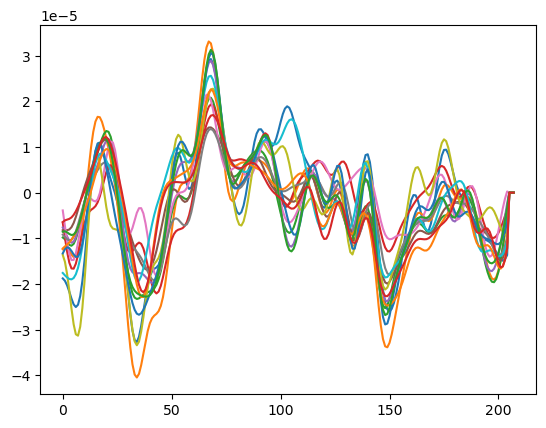

In [45]:
import matplotlib.pyplot as plt
plt.plot(d["X"][0].T)

In [46]:
total = 0
for f in train_files:
    total += len(np.load(f)["X"])
total

1243755

### Сборка всех субъектов для Benchmark

In [47]:
for sid, g in tqdm(bench_subjects.items()):
    build_subject_dataset(g, BENCH_ROOT)

  0%|          | 0/65 [00:00<?, ?it/s]

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\DynBigram\D_01_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\DynBigram\D_01_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\DynBigram\D_01_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\DynBigram\D_01_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\DynBigram\D_01_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\DynBigram\D_01_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\Dyn\D_01_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\Dyn\D_01_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\Dyn\D_01_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\Dyn\D_01_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\Dyn\D_01_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Test\Dyn\D_01_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Train\RC\D_01_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Train\RC\D_01_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Train\RC\D_01_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Train\RC\D_01_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Train\RC\D_01_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_01\SE001\Train\RC\D_01_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_01 → (8900, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\DynBigram\D_02_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\DynBigram\D_02_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\DynBigram\D_02_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\DynBigram\D_02_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\DynBigram\D_02_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\DynBigram\D_02_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\Dyn\D_02_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\Dyn\D_02_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\Dyn\D_02_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\Dyn\D_02_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\Dyn\D_02_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Test\Dyn\D_02_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Train\RC\D_02_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Train\RC\D_02_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Train\RC\D_02_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Train\RC\D_02_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Train\RC\D_02_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_02\SE001\Train\RC\D_02_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_02 → (9294, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\DynBigram\D_03_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\DynBigram\D_03_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\DynBigram\D_03_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\DynBigram\D_03_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\DynBigram\D_03_SE001_DynBigram_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\DynBigram\D_03_SE001_DynBigram_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\Dyn\D_03_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\Dyn\D_03_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\Dyn\D_03_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\Dyn\D_03_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\Dyn\D_03_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Test\Dyn\D_03_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Train\RC\D_03_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Train\RC\D_03_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Train\RC\D_03_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Train\RC\D_03_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Train\RC\D_03_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_03\SE001\Train\RC\D_03_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_03 → (11589, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\DynBigram\D_04_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\DynBigram\D_04_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\DynBigram\D_04_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\DynBigram\D_04_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\DynBigram\D_04_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\DynBigram\D_04_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\Dyn\D_04_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\Dyn\D_04_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\Dyn\D_04_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\Dyn\D_04_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\Dyn\D_04_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Test\Dyn\D_04_SE001_Dyn_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Train\RC\D_04_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Train\RC\D_04_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Train\RC\D_04_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Train\RC\D_04_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Train\RC\D_04_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_04\SE001\Train\RC\D_04_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_04 → (9665, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\DynBigram\D_05_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\DynBigram\D_05_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\DynBigram\D_05_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\DynBigram\D_05_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\DynBigram\D_05_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\DynBigram\D_05_SE001_DynBigram_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\Dyn\D_05_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\Dyn\D_05_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\Dyn\D_05_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\Dyn\D_05_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\Dyn\D_05_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Test\Dyn\D_05_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Train\RC\D_05_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Train\RC\D_05_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Train\RC\D_05_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Train\RC\D_05_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Train\RC\D_05_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_05\SE001\Train\RC\D_05_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_05 → (9768, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\DynBigram\D_06_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\DynBigram\D_06_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\DynBigram\D_06_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\DynBigram\D_06_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\DynBigram\D_06_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\DynBigram\D_06_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\Dyn\D_06_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\Dyn\D_06_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\Dyn\D_06_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\Dyn\D_06_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\Dyn\D_06_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Test\Dyn\D_06_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Train\RC\D_06_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Train\RC\D_06_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Train\RC\D_06_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Train\RC\D_06_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Train\RC\D_06_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_06\SE001\Train\RC\D_06_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_06 → (11031, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\DynBigram\D_07_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\DynBigram\D_07_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\DynBigram\D_07_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\DynBigram\D_07_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\DynBigram\D_07_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\DynBigram\D_07_SE001_DynBigram_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\Dyn\D_07_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\Dyn\D_07_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\Dyn\D_07_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\Dyn\D_07_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\Dyn\D_07_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Test\Dyn\D_07_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Train\RC\D_07_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Train\RC\D_07_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Train\RC\D_07_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Train\RC\D_07_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Train\RC\D_07_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_07\SE001\Train\RC\D_07_SE001_RC_Train07.edf 'Series' object has no attribute 'condition'
D_07 → (12271, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\DynBigram\D_08_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\DynBigram\D_08_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\DynBigram\D_08_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\DynBigram\D_08_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\DynBigram\D_08_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\DynBigram\D_08_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\Dyn\D_08_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\Dyn\D_08_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\Dyn\D_08_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\Dyn\D_08_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\Dyn\D_08_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Test\Dyn\D_08_SE001_Dyn_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Train\RC\D_08_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Train\RC\D_08_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Train\RC\D_08_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Train\RC\D_08_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Train\RC\D_08_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_08\SE001\Train\RC\D_08_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_08 → (10462, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\DynBigram\D_09_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\DynBigram\D_09_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\DynBigram\D_09_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\DynBigram\D_09_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\DynBigram\D_09_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\DynBigram\D_09_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\Dyn\D_09_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\Dyn\D_09_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\Dyn\D_09_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\Dyn\D_09_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\Dyn\D_09_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Test\Dyn\D_09_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Train\RC\D_09_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Train\RC\D_09_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Train\RC\D_09_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Train\RC\D_09_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Train\RC\D_09_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_09\SE001\Train\RC\D_09_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_09 → (9022, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\DynBigram\D_10_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\DynBigram\D_10_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\DynBigram\D_10_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\DynBigram\D_10_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\DynBigram\D_10_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\DynBigram\D_10_SE001_DynBigram_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\Dyn\D_10_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\Dyn\D_10_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\Dyn\D_10_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\Dyn\D_10_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\Dyn\D_10_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Test\Dyn\D_10_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Train\RC\D_10_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Train\RC\D_10_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Train\RC\D_10_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Train\RC\D_10_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Train\RC\D_10_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_10\SE001\Train\RC\D_10_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_10 → (8673, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\DynBigram\D_11_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\DynBigram\D_11_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\DynBigram\D_11_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\DynBigram\D_11_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\DynBigram\D_11_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\DynBigram\D_11_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\Dyn\D_11_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\Dyn\D_11_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\Dyn\D_11_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\Dyn\D_11_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\Dyn\D_11_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Test\Dyn\D_11_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Train\RC\D_11_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Train\RC\D_11_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Train\RC\D_11_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Train\RC\D_11_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Train\RC\D_11_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_11\SE001\Train\RC\D_11_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_11 → (15236, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\DynBigram\D_12_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\DynBigram\D_12_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\DynBigram\D_12_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\DynBigram\D_12_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\DynBigram\D_12_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\DynBigram\D_12_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\Dyn\D_12_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\Dyn\D_12_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\Dyn\D_12_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\Dyn\D_12_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\Dyn\D_12_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Test\Dyn\D_12_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Train\RC\D_12_SE001_RC_Train11.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Train\RC\D_12_SE001_RC_Train12.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Train\RC\D_12_SE001_RC_Train13.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Train\RC\D_12_SE001_RC_Train14.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Train\RC\D_12_SE001_RC_Train15.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_12\SE001\Train\RC\D_12_SE001_RC_Train16.edf 'Series' object has no attribute 'condition'
D_12 → (8156, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\DynBigram\D_13_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\DynBigram\D_13_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\DynBigram\D_13_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\DynBigram\D_13_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\DynBigram\D_13_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\DynBigram\D_13_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\Dyn\D_13_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\Dyn\D_13_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\Dyn\D_13_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\Dyn\D_13_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\Dyn\D_13_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Test\Dyn\D_13_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Train\RC\D_13_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Train\RC\D_13_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Train\RC\D_13_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Train\RC\D_13_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Train\RC\D_13_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_13\SE001\Train\RC\D_13_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_13 → (14856, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\DynBigram\D_14_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\DynBigram\D_14_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\DynBigram\D_14_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\DynBigram\D_14_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\DynBigram\D_14_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\DynBigram\D_14_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\Dyn\D_14_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\Dyn\D_14_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\Dyn\D_14_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\Dyn\D_14_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\Dyn\D_14_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Test\Dyn\D_14_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Train\RC\D_14_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Train\RC\D_14_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Train\RC\D_14_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Train\RC\D_14_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Train\RC\D_14_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_14\SE001\Train\RC\D_14_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_14 → (9748, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\DynBigram\D_15_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\DynBigram\D_15_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\DynBigram\D_15_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\DynBigram\D_15_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\DynBigram\D_15_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\DynBigram\D_15_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\Dyn\D_15_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\Dyn\D_15_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\Dyn\D_15_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\Dyn\D_15_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\Dyn\D_15_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Test\Dyn\D_15_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Train\RC\D_15_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Train\RC\D_15_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Train\RC\D_15_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Train\RC\D_15_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Train\RC\D_15_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_15\SE001\Train\RC\D_15_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_15 → (9188, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\DynBigram\D_16_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\DynBigram\D_16_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\DynBigram\D_16_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\DynBigram\D_16_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\DynBigram\D_16_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\DynBigram\D_16_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\Dyn\D_16_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\Dyn\D_16_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\Dyn\D_16_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\Dyn\D_16_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\Dyn\D_16_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Test\Dyn\D_16_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Train\RC\D_16_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Train\RC\D_16_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Train\RC\D_16_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Train\RC\D_16_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Train\RC\D_16_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_16\SE001\Train\RC\D_16_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_16 → (8622, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\DynBigram\D_17_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\DynBigram\D_17_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\DynBigram\D_17_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\DynBigram\D_17_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\DynBigram\D_17_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\DynBigram\D_17_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\DynBigram\D_17_SE001_DynBigram_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\Dyn\D_17_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\Dyn\D_17_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\Dyn\D_17_SE001_Dyn_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\Dyn\D_17_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\Dyn\D_17_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Test\Dyn\D_17_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Train\RC\D_17_SE001_RC_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Train\RC\D_17_SE001_RC_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Train\RC\D_17_SE001_RC_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Train\RC\D_17_SE001_RC_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Train\RC\D_17_SE001_RC_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyD\D_17\SE001\Train\RC\D_17_SE001_RC_Train06.edf 'Series' object has no attribute 'condition'
D_17 → (10299, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE001\Test\DynBigram\F_03_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE001\Test\DynBigram\F_03_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE001\Test\Dyn\F_03_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE001\Test\Dyn\F_03_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE001\Test\Static\F_03_SE001_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE001\Test\Static\F_03_SE001_Static_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE001\Train\CBCol\F_03_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


 C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE001\Train\CBCol\F_03_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE001\Train\CBCol\F_03_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE002\Test\DynBigram\F_03_SE002_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE002\Test\DynBigram\F_03_SE002_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE002\Test\Dyn\F_03_SE002_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE002\Test\Dyn\F_03_SE002_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE002\Test\Static\F_03_SE002_Static_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE002\Test\Static\F_03_SE002_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE002\Train\CBCol\F_03_SE002_CBCol_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE002\Train\CBCol\F_03_SE002_CBCol_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE002\Train\CBCol\F_03_SE002_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE003\Test\DynBigram\F_03_SE003_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE003\Test\DynBigram\F_03_SE003_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE003\Test\Dyn\F_03_SE003_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE003\Test\Dyn\F_03_SE003_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE003\Test\Static\F_03_SE003_Static_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE003\Test\Static\F_03_SE003_Static_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE003\Train\CBCol\F_03_SE003_CBCol_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE003\Train\CBCol\F_03_SE003_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_03\SE003\Train\CBCol\F_03_SE003_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


F_03 → (13351, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE001\Test\DynBigram\F_05_SE001_DynBigram_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE001\Test\DynBigram\F_05_SE001_DynBigram_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE001\Test\Dyn\F_05_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE001\Test\Dyn\F_05_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE001\Test\Static\F_05_SE001_Static_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE001\Test\Static\F_05_SE001_Static_Test10.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE001\Train\CBCol\F_05_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE001\Train\CBCol\F_05_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE001\Train\CBCol\F_05_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE002\Test\DynBigram\F_05_SE002_DynBigram_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE002\Test\DynBigram\F_05_SE002_DynBigram_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE002\Test\Dyn\F_05_SE002_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE002\Test\Dyn\F_05_SE002_Dyn_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE002\Test\Static\F_05_SE002_Static_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE002\Test\Static\F_05_SE002_Static_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE002\Train\CBCol\F_05_SE002_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE002\Train\CBCol\F_05_SE002_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE002\Train\CBCol\F_05_SE002_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE003\Test\DynBigram\F_05_SE003_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE003\Test\DynBigram\F_05_SE003_DynBigram_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE003\Test\Dyn\F_05_SE003_Dyn_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE003\Test\Dyn\F_05_SE003_Dyn_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE003\Test\Static\F_05_SE003_Static_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE003\Test\Static\F_05_SE003_Static_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE003\Train\CBCol\F_05_SE003_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE003\Train\CBCol\F_05_SE003_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_05\SE003\Train\CBCol\F_05_SE003_CBCol_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


F_05 → (12961, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE001\Test\DynBigram\F_06_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE001\Test\DynBigram\F_06_SE001_DynBigram_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE001\Test\Dyn\F_06_SE001_Dyn_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE001\Test\Dyn\F_06_SE001_Dyn_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE001\Test\Static\F_06_SE001_Static_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE001\Test\Static\F_06_SE001_Static_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE001\Train\CBCol\F_06_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE001\Train\CBCol\F_06_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE001\Train\CBCol\F_06_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE002\Test\DynBigram\F_06_SE002_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE002\Test\DynBigram\F_06_SE002_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE002\Test\Dyn\F_06_SE002_Dyn_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE002\Test\Dyn\F_06_SE002_Dyn_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE002\Test\Static\F_06_SE002_Static_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE002\Test\Static\F_06_SE002_Static_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE002\Train\CBCol\F_06_SE002_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE002\Train\CBCol\F_06_SE002_CBCol_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE002\Train\CBCol\F_06_SE002_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE003\Test\DynBigram\F_06_SE003_DynBigram_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE003\Test\DynBigram\F_06_SE003_DynBigram_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE003\Test\Dyn\F_06_SE003_Dyn_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE003\Test\Dyn\F_06_SE003_Dyn_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE003\Test\Static\F_06_SE003_Static_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE003\Test\Static\F_06_SE003_Static_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE003\Train\CBCol\F_06_SE003_CBCol_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE003\Train\CBCol\F_06_SE003_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_06\SE003\Train\CBCol\F_06_SE003_CBCol_Train03.edf 'Series' object has no attribute 'condition'
F_06 → (19162, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE001\Test\DynBigram\F_07_SE001_DynBigram_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE001\Test\DynBigram\F_07_SE001_DynBigram_Test10.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE001\Test\Dyn\F_07_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE001\Test\Dyn\F_07_SE001_Dyn_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE001\Test\Static\F_07_SE001_Static_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE001\Test\Static\F_07_SE001_Static_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE001\Train\CBCol\F_07_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE001\Train\CBCol\F_07_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE001\Train\CBCol\F_07_SE001_CBCol_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE002\Test\DynBigram\F_07_SE002_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE002\Test\DynBigram\F_07_SE002_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE002\Test\Dyn\F_07_SE002_Dyn_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE002\Test\Dyn\F_07_SE002_Dyn_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE002\Test\Static\F_07_SE002_Static_Test08.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE002\Test\Static\F_07_SE002_Static_Test09.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE002\Train\CBCol\F_07_SE002_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE002\Train\CBCol\F_07_SE002_CBCol_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE002\Train\CBCol\F_07_SE002_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE003\Test\DynBigram\F_07_SE003_DynBigram_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE003\Test\DynBigram\F_07_SE003_DynBigram_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE003\Test\Dyn\F_07_SE003_Dyn_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE003\Test\Dyn\F_07_SE003_Dyn_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE003\Test\Static\F_07_SE003_Static_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE003\Test\Static\F_07_SE003_Static_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE003\Train\CBCol\F_07_SE003_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE003\Train\CBCol\F_07_SE003_CBCol_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_07\SE003\Train\CBCol\F_07_SE003_CBCol_Train03.edf 'Series' object has no attribute 'condition'
F_07 → (19786, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE001\Test\DynBigram\F_08_SE001_DynBigram_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE001\Test\DynBigram\F_08_SE001_DynBigram_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE001\Test\Dyn\F_08_SE001_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE001\Test\Dyn\F_08_SE001_Dyn_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE001\Test\Static\F_08_SE001_Static_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE001\Test\Static\F_08_SE001_Static_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE001\Train\CBCol\F_08_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE001\Train\CBCol\F_08_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE001\Train\CBCol\F_08_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE002\Test\DynBigram\F_08_SE002_DynBigram_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE002\Test\DynBigram\F_08_SE002_DynBigram_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE002\Test\Dyn\F_08_SE002_Dyn_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE002\Test\Dyn\F_08_SE002_Dyn_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE002\Test\Static\F_08_SE002_Static_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE002\Test\Static\F_08_SE002_Static_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE002\Train\CBCol\F_08_SE002_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE002\Train\CBCol\F_08_SE002_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE002\Train\CBCol\F_08_SE002_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE003\Test\DynBigram\F_08_SE003_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE003\Test\DynBigram\F_08_SE003_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE003\Test\Dyn\F_08_SE003_Dyn_Test08.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE003\Test\Dyn\F_08_SE003_Dyn_Test09.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE003\Test\Static\F_08_SE003_Static_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE003\Test\Static\F_08_SE003_Static_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE003\Train\CBCol\F_08_SE003_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE003\Train\CBCol\F_08_SE003_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_08\SE003\Train\CBCol\F_08_SE003_CBCol_Train03.edf 'Series' object has no attribute 'condition'
F_08 → (12674, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE001\Test\DynBigram\F_20_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE001\Test\DynBigram\F_20_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE001\Test\Dyn\F_20_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE001\Test\Dyn\F_20_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE001\Test\Static\F_20_SE001_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE001\Test\Static\F_20_SE001_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE001\Train\CBCol\F_20_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE001\Train\CBCol\F_20_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE001\Train\CBCol\F_20_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE002\Test\DynBigram\F_20_SE002_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE002\Test\DynBigram\F_20_SE002_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE002\Test\Dyn\F_20_SE002_Dyn_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE002\Test\Dyn\F_20_SE002_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE002\Test\Static\F_20_SE002_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE002\Test\Static\F_20_SE002_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE002\Train\CBCol\F_20_SE002_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE002\Train\CBCol\F_20_SE002_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE002\Train\CBCol\F_20_SE002_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE003\Test\DynBigram\F_20_SE003_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE003\Test\DynBigram\F_20_SE003_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE003\Test\Dyn\F_20_SE003_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE003\Test\Dyn\F_20_SE003_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE003\Test\Static\F_20_SE003_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE003\Test\Static\F_20_SE003_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE003\Train\CBCol\F_20_SE003_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE003\Train\CBCol\F_20_SE003_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_20\SE003\Train\CBCol\F_20_SE003_CBCol_Train03.edf 'Series' object has no attribute 'condition'
F_20 → (13573, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE001\Test\DynBigram\F_21_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE001\Test\DynBigram\F_21_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE001\Test\Dyn\F_21_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE001\Test\Dyn\F_21_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE001\Test\Static\F_21_SE001_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE001\Test\Static\F_21_SE001_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE001\Train\CBCol\F_21_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE001\Train\CBCol\F_21_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE001\Train\CBCol\F_21_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE002\Test\DynBigram\F_21_SE002_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE002\Test\DynBigram\F_21_SE002_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE002\Test\Dyn\F_21_SE002_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE002\Test\Dyn\F_21_SE002_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE002\Test\Static\F_21_SE002_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE002\Test\Static\F_21_SE002_Static_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE002\Train\CBCol\F_21_SE002_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE002\Train\CBCol\F_21_SE002_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE002\Train\CBCol\F_21_SE002_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE003\Test\DynBigram\F_21_SE003_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE003\Test\DynBigram\F_21_SE003_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE003\Test\Dyn\F_21_SE003_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE003\Test\Dyn\F_21_SE003_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE003\Test\Static\F_21_SE003_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE003\Test\Static\F_21_SE003_Static_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE003\Train\CBCol\F_21_SE003_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE003\Train\CBCol\F_21_SE003_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_21\SE003\Train\CBCol\F_21_SE003_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


F_21 → (13517, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE001\Test\DynBigram\F_23_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE001\Test\DynBigram\F_23_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE001\Test\Dyn\F_23_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE001\Test\Dyn\F_23_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE001\Test\Static\F_23_SE001_Static_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE001\Test\Static\F_23_SE001_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE001\Train\CBCol\F_23_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE001\Train\CBCol\F_23_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE001\Train\CBCol\F_23_SE001_CBCol_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE002\Test\DynBigram\F_23_SE002_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE002\Test\DynBigram\F_23_SE002_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE002\Test\Dyn\F_23_SE002_Dyn_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE002\Test\Dyn\F_23_SE002_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE002\Test\Static\F_23_SE002_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE002\Test\Static\F_23_SE002_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE002\Train\CBCol\F_23_SE002_CBCol_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE002\Train\CBCol\F_23_SE002_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE002\Train\CBCol\F_23_SE002_CBCol_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE003\Test\DynBigram\F_23_SE003_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE003\Test\DynBigram\F_23_SE003_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE003\Test\Dyn\F_23_SE003_Dyn_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE003\Test\Dyn\F_23_SE003_Dyn_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE003\Test\Static\F_23_SE003_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE003\Test\Static\F_23_SE003_Static_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE003\Train\CBCol\F_23_SE003_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE003\Train\CBCol\F_23_SE003_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_23\SE003\Train\CBCol\F_23_SE003_CBCol_Train03.edf 'Series' object has no attribute 'condition'
F_23 → (18620, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE001\Test\DynBigram\F_24_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE001\Test\DynBigram\F_24_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE001\Test\Dyn\F_24_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE001\Test\Dyn\F_24_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE001\Test\Static\F_24_SE001_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE001\Test\Static\F_24_SE001_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE001\Train\CBCol\F_24_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE001\Train\CBCol\F_24_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE001\Train\CBCol\F_24_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE002\Test\DynBigram\F_24_SE002_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE002\Test\DynBigram\F_24_SE002_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE002\Test\Dyn\F_24_SE002_Dyn_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE002\Test\Dyn\F_24_SE002_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE002\Test\Static\F_24_SE002_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE002\Test\Static\F_24_SE002_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE002\Train\CBCol\F_24_SE002_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE002\Train\CBCol\F_24_SE002_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE002\Train\CBCol\F_24_SE002_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE003\Test\DynBigram\F_24_SE003_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE003\Test\DynBigram\F_24_SE003_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE003\Test\Dyn\F_24_SE003_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE003\Test\Dyn\F_24_SE003_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE003\Test\Static\F_24_SE003_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE003\Test\Static\F_24_SE003_Static_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE003\Train\CBCol\F_24_SE003_CBCol_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE003\Train\CBCol\F_24_SE003_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_24\SE003\Train\CBCol\F_24_SE003_CBCol_Train03.edf 'Series' object has no attribute 'condition'
F_24 → (14204, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE001\Test\DynBigram\F_25_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE001\Test\DynBigram\F_25_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE001\Test\Dyn\F_25_SE001_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE001\Test\Dyn\F_25_SE001_Dyn_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE001\Test\Static\F_25_SE001_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE001\Test\Static\F_25_SE001_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE001\Train\CBCol\F_25_SE001_CBCol_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE001\Train\CBCol\F_25_SE001_CBCol_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE001\Train\CBCol\F_25_SE001_CBCol_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE002\Test\DynBigram\F_25_SE002_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE002\Test\DynBigram\F_25_SE002_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE002\Test\Dyn\F_25_SE002_Dyn_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE002\Test\Dyn\F_25_SE002_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE002\Test\Static\F_25_SE002_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE002\Test\Static\F_25_SE002_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE002\Train\CBCol\F_25_SE002_CBCol_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE002\Train\CBCol\F_25_SE002_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE002\Train\CBCol\F_25_SE002_CBCol_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE003\Test\DynBigram\F_25_SE003_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE003\Test\DynBigram\F_25_SE003_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE003\Test\Dyn\F_25_SE003_Dyn_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE003\Test\Dyn\F_25_SE003_Dyn_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE003\Test\Static\F_25_SE003_Static_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE003\Test\Static\F_25_SE003_Static_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE003\Train\CBCol\F_25_SE003_CBCol_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE003\Train\CBCol\F_25_SE003_CBCol_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyF\F_25\SE003\Train\CBCol\F_25_SE003_CBCol_Train03.edf 'Series' object has no attribute 'condition'
F_25 → (15354, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Test\DynBigram\G_01_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Test\DynBigram\G_01_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Test\DynBigram\G_01_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Test\DynBigram\G_01_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Test\DynBigram\G_01_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Test\DynNgram\G_01_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Test\DynNgram\G_01_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Test\DynNgram\G_01_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Test\DynNgram\G_01_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Test\DynNgram\G_01_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Train\CB\G_01_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Train\CB\G_01_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Train\CB\G_01_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Train\CB\G_01_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Train\CB\G_01_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_01\SE001\Train\CB\G_01_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_01 → (7360, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Test\DynBigram\G_02_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Test\DynBigram\G_02_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Test\DynBigram\G_02_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Test\DynBigram\G_02_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Test\DynBigram\G_02_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Test\DynNgram\G_02_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Test\DynNgram\G_02_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Test\DynNgram\G_02_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Test\DynNgram\G_02_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Test\DynNgram\G_02_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Train\CB\G_02_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Train\CB\G_02_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Train\CB\G_02_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Train\CB\G_02_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Train\CB\G_02_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_02\SE001\Train\CB\G_02_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_02 → (6037, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Test\DynBigram\G_03_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Test\DynBigram\G_03_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Test\DynBigram\G_03_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Test\DynBigram\G_03_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Test\DynBigram\G_03_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Test\DynNgram\G_03_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Test\DynNgram\G_03_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Test\DynNgram\G_03_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Test\DynNgram\G_03_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Test\DynNgram\G_03_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Train\CB\G_03_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Train\CB\G_03_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Train\CB\G_03_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Train\CB\G_03_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Train\CB\G_03_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_03\SE001\Train\CB\G_03_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


G_03 → (6825, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Test\DynBigram\G_04_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Test\DynBigram\G_04_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Test\DynBigram\G_04_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Test\DynBigram\G_04_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Test\DynBigram\G_04_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Test\DynNgram\G_04_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Test\DynNgram\G_04_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Test\DynNgram\G_04_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Test\DynNgram\G_04_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Test\DynNgram\G_04_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Train\CB\G_04_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Train\CB\G_04_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Train\CB\G_04_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Train\CB\G_04_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Train\CB\G_04_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_04\SE001\Train\CB\G_04_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


G_04 → (6829, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Test\DynBigram\G_05_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Test\DynBigram\G_05_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Test\DynBigram\G_05_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Test\DynBigram\G_05_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Test\DynBigram\G_05_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Test\DynNgram\G_05_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Test\DynNgram\G_05_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Test\DynNgram\G_05_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Test\DynNgram\G_05_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Test\DynNgram\G_05_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Train\CB\G_05_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Train\CB\G_05_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Train\CB\G_05_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Train\CB\G_05_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Train\CB\G_05_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_05\SE001\Train\CB\G_05_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_05 → (6076, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Test\DynBigram\G_06_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Test\DynBigram\G_06_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Test\DynBigram\G_06_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Test\DynBigram\G_06_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Test\DynBigram\G_06_SE001_DynBigram_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Test\DynNgram\G_06_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Test\DynNgram\G_06_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Test\DynNgram\G_06_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Test\DynNgram\G_06_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Test\DynNgram\G_06_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Train\CB\G_06_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Train\CB\G_06_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Train\CB\G_06_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Train\CB\G_06_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Train\CB\G_06_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


 C:\data_bigp3bci\bigP3BCI-data\StudyG\G_06\SE001\Train\CB\G_06_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_06 → (10796, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Test\DynBigram\G_07_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Test\DynBigram\G_07_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Test\DynBigram\G_07_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Test\DynBigram\G_07_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Test\DynBigram\G_07_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Test\DynNgram\G_07_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Test\DynNgram\G_07_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Test\DynNgram\G_07_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Test\DynNgram\G_07_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Test\DynNgram\G_07_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Train\CB\G_07_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Train\CB\G_07_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Train\CB\G_07_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Train\CB\G_07_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Train\CB\G_07_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_07\SE001\Train\CB\G_07_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_07 → (6362, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Test\DynBigram\G_08_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Test\DynBigram\G_08_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Test\DynBigram\G_08_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Test\DynBigram\G_08_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Test\DynBigram\G_08_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Test\DynNgram\G_08_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Test\DynNgram\G_08_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Test\DynNgram\G_08_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Test\DynNgram\G_08_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


 C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Test\DynNgram\G_08_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Train\CB\G_08_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Train\CB\G_08_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Train\CB\G_08_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Train\CB\G_08_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Train\CB\G_08_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_08\SE001\Train\CB\G_08_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


G_08 → (6539, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Test\DynBigram\G_09_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Test\DynBigram\G_09_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Test\DynBigram\G_09_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Test\DynBigram\G_09_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Test\DynBigram\G_09_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Test\DynNgram\G_09_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Test\DynNgram\G_09_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Test\DynNgram\G_09_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Test\DynNgram\G_09_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Test\DynNgram\G_09_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Train\CB\G_09_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Train\CB\G_09_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Train\CB\G_09_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Train\CB\G_09_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Train\CB\G_09_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_09\SE001\Train\CB\G_09_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_09 → (8864, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Test\DynBigram\G_10_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Test\DynBigram\G_10_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Test\DynBigram\G_10_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


 C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Test\DynBigram\G_10_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Test\DynBigram\G_10_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Test\DynNgram\G_10_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Test\DynNgram\G_10_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Test\DynNgram\G_10_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Test\DynNgram\G_10_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Test\DynNgram\G_10_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Train\CB\G_10_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Train\CB\G_10_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Train\CB\G_10_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Train\CB\G_10_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Train\CB\G_10_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_10\SE001\Train\CB\G_10_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_10 → (6912, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Test\DynBigram\G_11_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Test\DynBigram\G_11_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Test\DynBigram\G_11_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Test\DynBigram\G_11_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Test\DynBigram\G_11_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Test\DynNgram\G_11_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Test\DynNgram\G_11_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Test\DynNgram\G_11_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Test\DynNgram\G_11_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Test\DynNgram\G_11_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Train\CB\G_11_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Train\CB\G_11_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Train\CB\G_11_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Train\CB\G_11_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Train\CB\G_11_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_11\SE001\Train\CB\G_11_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


G_11 → (7377, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Test\DynBigram\G_12_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Test\DynBigram\G_12_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Test\DynBigram\G_12_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Test\DynBigram\G_12_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Test\DynBigram\G_12_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Test\DynNgram\G_12_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Test\DynNgram\G_12_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Test\DynNgram\G_12_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Test\DynNgram\G_12_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Test\DynNgram\G_12_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Train\CB\G_12_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Train\CB\G_12_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Train\CB\G_12_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Train\CB\G_12_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Train\CB\G_12_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_12\SE001\Train\CB\G_12_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_12 → (5968, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Test\DynBigram\G_13_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Test\DynBigram\G_13_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Test\DynBigram\G_13_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Test\DynBigram\G_13_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Test\DynBigram\G_13_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Test\DynNgram\G_13_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Test\DynNgram\G_13_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Test\DynNgram\G_13_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Test\DynNgram\G_13_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Test\DynNgram\G_13_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Train\CB\G_13_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Train\CB\G_13_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Train\CB\G_13_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Train\CB\G_13_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Train\CB\G_13_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_13\SE001\Train\CB\G_13_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_13 → (8006, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Test\DynBigram\G_14_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Test\DynBigram\G_14_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Test\DynBigram\G_14_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Test\DynBigram\G_14_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Test\DynBigram\G_14_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Test\DynNgram\G_14_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Test\DynNgram\G_14_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Test\DynNgram\G_14_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Test\DynNgram\G_14_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Test\DynNgram\G_14_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Train\CB\G_14_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Train\CB\G_14_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Train\CB\G_14_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Train\CB\G_14_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Train\CB\G_14_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_14\SE001\Train\CB\G_14_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_14 → (6415, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Test\DynBigram\G_15_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Test\DynBigram\G_15_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Test\DynBigram\G_15_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Test\DynBigram\G_15_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Test\DynBigram\G_15_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Test\DynNgram\G_15_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Test\DynNgram\G_15_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Test\DynNgram\G_15_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Test\DynNgram\G_15_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Test\DynNgram\G_15_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Train\CB\G_15_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Train\CB\G_15_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Train\CB\G_15_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Train\CB\G_15_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Train\CB\G_15_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_15\SE001\Train\CB\G_15_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_15 → (8947, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Test\DynBigram\G_16_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Test\DynBigram\G_16_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Test\DynBigram\G_16_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Test\DynBigram\G_16_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Test\DynBigram\G_16_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Test\DynNgram\G_16_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Test\DynNgram\G_16_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Test\DynNgram\G_16_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Test\DynNgram\G_16_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Test\DynNgram\G_16_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Train\CB\G_16_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Train\CB\G_16_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Train\CB\G_16_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Train\CB\G_16_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Train\CB\G_16_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_16\SE001\Train\CB\G_16_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
G_16 → (7908, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Test\DynBigram\G_17_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Test\DynBigram\G_17_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Test\DynBigram\G_17_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Test\DynBigram\G_17_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Test\DynBigram\G_17_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Test\DynNgram\G_17_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Test\DynNgram\G_17_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Test\DynNgram\G_17_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Test\DynNgram\G_17_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Test\DynNgram\G_17_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Train\CB\G_17_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Train\CB\G_17_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Train\CB\G_17_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Train\CB\G_17_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Train\CB\G_17_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_17\SE001\Train\CB\G_17_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


G_17 → (7787, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Test\DynBigram\G_18_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Test\DynBigram\G_18_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Test\DynBigram\G_18_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Test\DynBigram\G_18_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Test\DynBigram\G_18_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Test\DynNgram\G_18_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Test\DynNgram\G_18_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Test\DynNgram\G_18_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Test\DynNgram\G_18_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Test\DynNgram\G_18_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Train\CB\G_18_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Train\CB\G_18_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Train\CB\G_18_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Train\CB\G_18_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Train\CB\G_18_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_18\SE001\Train\CB\G_18_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


G_18 → (7993, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Test\DynBigram\G_19_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Test\DynBigram\G_19_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Test\DynBigram\G_19_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Test\DynBigram\G_19_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Test\DynBigram\G_19_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Test\DynNgram\G_19_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Test\DynNgram\G_19_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Test\DynNgram\G_19_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Test\DynNgram\G_19_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Test\DynNgram\G_19_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Train\CB\G_19_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Train\CB\G_19_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Train\CB\G_19_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Train\CB\G_19_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Train\CB\G_19_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_19\SE001\Train\CB\G_19_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


G_19 → (6821, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Test\DynBigram\G_20_SE001_DynBigram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Test\DynBigram\G_20_SE001_DynBigram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Test\DynBigram\G_20_SE001_DynBigram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Test\DynBigram\G_20_SE001_DynBigram_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Test\DynBigram\G_20_SE001_DynBigram_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Test\DynNgram\G_20_SE001_DynNgram_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Test\DynNgram\G_20_SE001_DynNgram_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Test\DynNgram\G_20_SE001_DynNgram_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Test\DynNgram\G_20_SE001_DynNgram_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Test\DynNgram\G_20_SE001_DynNgram_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Train\CB\G_20_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Train\CB\G_20_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Train\CB\G_20_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Train\CB\G_20_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Train\CB\G_20_SE001_CB_Train06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyG\G_20\SE001\Train\CB\G_20_SE001_CB_Train07.edf 'Series' object has no attribute 'condition'
G_20 → (6099, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\CB\I_01_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\CB\I_01_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\CB\I_01_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\CB\I_01_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\CB\I_01_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\CB\I_01_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\PB\I_01_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\PB\I_01_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\PB\I_01_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\PB\I_01_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\PB\I_01_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Test\PB\I_01_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Train\CB\I_01_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Train\CB\I_01_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Train\CB\I_01_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Train\CB\I_01_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Train\PB\I_01_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Train\PB\I_01_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Train\PB\I_01_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_01\SE001\Train\PB\I_01_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'
I_01 → (12389, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\CB\I_02_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\CB\I_02_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\CB\I_02_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\CB\I_02_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\CB\I_02_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\CB\I_02_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\PB\I_02_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\PB\I_02_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\PB\I_02_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\PB\I_02_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\PB\I_02_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Test\PB\I_02_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Train\CB\I_02_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Train\CB\I_02_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Train\CB\I_02_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Train\CB\I_02_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Train\PB\I_02_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Train\PB\I_02_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Train\PB\I_02_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_02\SE001\Train\PB\I_02_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


I_02 → (10506, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\CB\I_03_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\CB\I_03_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\CB\I_03_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\CB\I_03_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\CB\I_03_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\CB\I_03_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\PB\I_03_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\PB\I_03_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\PB\I_03_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\PB\I_03_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\PB\I_03_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Test\PB\I_03_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Train\CB\I_03_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Train\CB\I_03_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Train\CB\I_03_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Train\CB\I_03_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Train\PB\I_03_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Train\PB\I_03_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Train\PB\I_03_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_03\SE001\Train\PB\I_03_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'
I_03 → (13283, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\CB\I_04_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\CB\I_04_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\CB\I_04_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\CB\I_04_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\CB\I_04_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\CB\I_04_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\PB\I_04_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\PB\I_04_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\PB\I_04_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\PB\I_04_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\PB\I_04_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Test\PB\I_04_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Train\CB\I_04_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Train\CB\I_04_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Train\CB\I_04_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Train\CB\I_04_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Train\PB\I_04_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Train\PB\I_04_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Train\PB\I_04_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_04\SE001\Train\PB\I_04_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'
I_04 → (9725, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\CB\I_05_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\CB\I_05_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\CB\I_05_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\CB\I_05_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\CB\I_05_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\CB\I_05_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\PB\I_05_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\PB\I_05_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\PB\I_05_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\PB\I_05_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\PB\I_05_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Test\PB\I_05_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Train\CB\I_05_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Train\CB\I_05_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Train\CB\I_05_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Train\CB\I_05_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Train\PB\I_05_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Train\PB\I_05_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Train\PB\I_05_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_05\SE001\Train\PB\I_05_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'
I_05 → (12789, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\CB\I_06_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\CB\I_06_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\CB\I_06_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\CB\I_06_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\CB\I_06_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\CB\I_06_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\PB\I_06_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\PB\I_06_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\PB\I_06_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\PB\I_06_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\PB\I_06_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Test\PB\I_06_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Train\CB\I_06_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Train\CB\I_06_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Train\CB\I_06_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Train\CB\I_06_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Train\PB\I_06_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Train\PB\I_06_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Train\PB\I_06_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Train\PB\I_06_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_06\SE001\Train\PB\I_06_SE001_PB_Train05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


I_06 → (8494, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\CB\I_07_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\CB\I_07_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\CB\I_07_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\CB\I_07_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\CB\I_07_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\CB\I_07_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\CB\I_07_SE001_CB_Test07.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\PB\I_07_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\PB\I_07_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\PB\I_07_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\PB\I_07_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\PB\I_07_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\PB\I_07_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Test\PB\I_07_SE001_PB_Test07.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Train\CB\I_07_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Train\CB\I_07_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Train\CB\I_07_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Train\CB\I_07_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Train\CB\I_07_SE001_CB_Train05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Train\PB\I_07_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Train\PB\I_07_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Train\PB\I_07_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Train\PB\I_07_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_07\SE001\Train\PB\I_07_SE001_PB_Train05.edf 'Series' object has no attribute 'condition'
I_07 → (16866, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\CB\I_08_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\CB\I_08_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\CB\I_08_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\CB\I_08_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\CB\I_08_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\CB\I_08_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\PB\I_08_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\PB\I_08_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\PB\I_08_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\PB\I_08_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\PB\I_08_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Test\PB\I_08_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Train\CB\I_08_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Train\CB\I_08_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Train\CB\I_08_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Train\CB\I_08_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Train\PB\I_08_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Train\PB\I_08_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Train\PB\I_08_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_08\SE001\Train\PB\I_08_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


I_08 → (11346, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\CB\I_09_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\CB\I_09_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\CB\I_09_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\CB\I_09_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\CB\I_09_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\CB\I_09_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\PB\I_09_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\PB\I_09_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\PB\I_09_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\PB\I_09_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\PB\I_09_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Test\PB\I_09_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Train\CB\I_09_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Train\CB\I_09_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Train\CB\I_09_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Train\CB\I_09_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Train\PB\I_09_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Train\PB\I_09_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Train\PB\I_09_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_09\SE001\Train\PB\I_09_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'
I_09 → (8880, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

 C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\CB\I_10_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\CB\I_10_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\CB\I_10_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\CB\I_10_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\CB\I_10_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\CB\I_10_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\PB\I_10_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\PB\I_10_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\PB\I_10_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\PB\I_10_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\PB\I_10_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Test\PB\I_10_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Train\CB\I_10_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Train\CB\I_10_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Train\CB\I_10_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

 C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Train\CB\I_10_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Train\PB\I_10_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Train\PB\I_10_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Train\PB\I_10_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_10\SE001\Train\PB\I_10_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'
I_10 → (12383, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\CB\I_11_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\CB\I_11_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\CB\I_11_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\CB\I_11_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\CB\I_11_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\CB\I_11_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\PB\I_11_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\PB\I_11_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\PB\I_11_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\PB\I_11_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\PB\I_11_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Test\PB\I_11_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Train\CB\I_11_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Train\CB\I_11_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Train\CB\I_11_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Train\CB\I_11_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Train\PB\I_11_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Train\PB\I_11_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Train\PB\I_11_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_11\SE001\Train\PB\I_11_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'
I_11 → (10146, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\CB\I_12_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\CB\I_12_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\CB\I_12_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\CB\I_12_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\CB\I_12_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\CB\I_12_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\PB\I_12_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\PB\I_12_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\PB\I_12_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\PB\I_12_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\PB\I_12_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Test\PB\I_12_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Train\CB\I_12_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Train\CB\I_12_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Train\CB\I_12_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Train\CB\I_12_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Train\PB\I_12_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Train\PB\I_12_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Train\PB\I_12_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR:

C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


 C:\data_bigp3bci\bigP3BCI-data\StudyI\I_12\SE001\Train\PB\I_12_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'
I_12 → (12738, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\CB\I_13_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\CB\I_13_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\CB\I_13_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\CB\I_13_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\CB\I_13_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\CB\I_13_SE001_CB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\PB\I_13_SE001_PB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\PB\I_13_SE001_PB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\PB\I_13_SE001_PB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\PB\I_13_SE001_PB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\PB\I_13_SE001_PB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Test\PB\I_13_SE001_PB_Test06.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Train\CB\I_13_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Train\CB\I_13_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Train\CB\I_13_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Train\CB\I_13_SE001_CB_Train04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Train\PB\I_13_SE001_PB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Train\PB\I_13_SE001_PB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Train\PB\I_13_SE001_PB_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyI\I_13\SE001\Train\PB\I_13_SE001_PB_Train04.edf 'Series' object has no attribute 'condition'
I_13 → (12223, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Test\AD\K_01_SE001_AD_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Test\AD\K_01_SE001_AD_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Test\AD\K_01_SE001_AD_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Test\AD\K_01_SE001_AD_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Test\AD\K_01_SE001_AD_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Test\CB\K_01_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Test\CB\K_01_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Test\CB\K_01_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Test\CB\K_01_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Test\CB\K_01_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Train\AD\K_01_SE001_AD_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Train\AD\K_01_SE001_AD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Train\AD\K_01_SE001_AD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Train\CB\K_01_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Train\CB\K_01_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE001\Train\CB\K_01_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Test\AD\K_01_SE002_AD_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Test\AD\K_01_SE002_AD_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Test\AD\K_01_SE002_AD_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Test\AD\K_01_SE002_AD_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Test\AD\K_01_SE002_AD_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Test\CB\K_01_SE002_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Test\CB\K_01_SE002_CB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Test\CB\K_01_SE002_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Test\CB\K_01_SE002_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Test\CB\K_01_SE002_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Train\AD\K_01_SE002_AD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Train\AD\K_01_SE002_AD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Train\AD\K_01_SE002_AD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Train\CB\K_01_SE002_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Train\CB\K_01_SE002_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_01\SE002\Train\CB\K_01_SE002_CB_Train03.edf 'Series' object has no attribute 'condition'
K_01 → (16711, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Test\AD\K_02_SE001_AD_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Test\AD\K_02_SE001_AD_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Test\AD\K_02_SE001_AD_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Test\AD\K_02_SE001_AD_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Test\AD\K_02_SE001_AD_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Test\CB\K_02_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Test\CB\K_02_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Test\CB\K_02_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Test\CB\K_02_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Test\CB\K_02_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Train\AD\K_02_SE001_AD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Train\AD\K_02_SE001_AD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Train\AD\K_02_SE001_AD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Train\CB\K_02_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Train\CB\K_02_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_02\SE001\Train\CB\K_02_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
K_02 → (7762, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Test\AD\K_03_SE001_AD_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Test\AD\K_03_SE001_AD_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Test\AD\K_03_SE001_AD_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Test\AD\K_03_SE001_AD_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Test\AD\K_03_SE001_AD_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Test\CB\K_03_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Test\CB\K_03_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Test\CB\K_03_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Test\CB\K_03_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Test\CB\K_03_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Train\AD\K_03_SE001_AD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Train\AD\K_03_SE001_AD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Train\AD\K_03_SE001_AD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Train\CB\K_03_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Train\CB\K_03_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE001\Train\CB\K_03_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Test\AD\K_03_SE002_AD_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Test\AD\K_03_SE002_AD_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Test\AD\K_03_SE002_AD_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Test\AD\K_03_SE002_AD_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Test\AD\K_03_SE002_AD_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Test\CB\K_03_SE002_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Test\CB\K_03_SE002_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Test\CB\K_03_SE002_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Test\CB\K_03_SE002_CB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Test\CB\K_03_SE002_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Train\AD\K_03_SE002_AD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Train\AD\K_03_SE002_AD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Train\AD\K_03_SE002_AD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Train\CB\K_03_SE002_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Train\CB\K_03_SE002_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_03\SE002\Train\CB\K_03_SE002_CB_Train03.edf 'Series' object has no attribute 'condition'
K_03 → (24030, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Test\AD\K_04_SE001_AD_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Test\AD\K_04_SE001_AD_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Test\AD\K_04_SE001_AD_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Test\AD\K_04_SE001_AD_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Test\AD\K_04_SE001_AD_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Test\CB\K_04_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Test\CB\K_04_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Test\CB\K_04_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Test\CB\K_04_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Test\CB\K_04_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Train\AD\K_04_SE001_AD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Train\AD\K_04_SE001_AD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Train\AD\K_04_SE001_AD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Train\CB\K_04_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Train\CB\K_04_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE001\Train\CB\K_04_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Test\AD\K_04_SE002_AD_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Test\AD\K_04_SE002_AD_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Test\AD\K_04_SE002_AD_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Test\AD\K_04_SE002_AD_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Test\AD\K_04_SE002_AD_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Test\CB\K_04_SE002_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Test\CB\K_04_SE002_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Test\CB\K_04_SE002_CB_Test03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Test\CB\K_04_SE002_CB_Test04.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Test\CB\K_04_SE002_CB_Test05.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Train\AD\K_04_SE002_AD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Train\AD\K_04_SE002_AD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Train\AD\K_04_SE002_AD_Train03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Train\CB\K_04_SE002_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Train\CB\K_04_SE002_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_04\SE002\Train\CB\K_04_SE002_CB_Train03.edf 'Series' object has no attribute 'condition'
K_04 → (16353, 14, 208)
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Test\AD\K_09_SE001_AD_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Test\AD\K_09_SE001_AD_Test02.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Test\AD\K_09_SE001_AD_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Test\AD\K_09_SE001_AD_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Test\AD\K_09_SE001_AD_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Test\CB\K_09_SE001_CB_Test01.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:

ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Test\CB\K_09_SE001_CB_Test02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Test\CB\K_09_SE001_CB_Test03.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Test\CB\K_09_SE001_CB_Test04.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Test\CB\K_09_SE001_CB_Test05.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Train\AD\K_09_SE001_AD_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Train\AD\K_09_SE001_AD_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.
ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Train\AD\K_09_SE001_AD_Train03.edf 'Series' object has no attribute 'condition'


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Train\CB\K_09_SE001_CB_Train01.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Train\CB\K_09_SE001_CB_Train02.edf 'Series' object has no attribute 'condition'
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\3278204042.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_5236\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


ERROR: C:\data_bigp3bci\bigP3BCI-data\StudyK\K_09\SE001\Train\CB\K_09_SE001_CB_Train03.edf 'Series' object has no attribute 'condition'
K_09 → (11053, 14, 208)


#### Проверки

In [48]:
bench_files = list(BENCH_ROOT.glob("*.npz"))
len(bench_files), len(bench_subjects)

(65, 65)

In [49]:
for f in bench_files[:3]:
    d = np.load(f)
    print(f.name, d["X"].shape)

subj_051.npz (8900, 14, 208)
subj_052.npz (9294, 14, 208)
subj_053.npz (11589, 14, 208)


In [50]:
np.load(bench_files[0])["X"].shape[2]

208

In [51]:
d = np.load(bench_files[0])
np.sum(np.all(d["X"]==0, axis=(1,2)))

np.int64(0)

In [52]:
float((d["y"]==1).mean())

0.11842696629213482

In [53]:
sizes = [len(np.load(f)["X"]) for f in bench_files]
min(sizes), max(sizes), np.mean(sizes)

(5968, 24030, np.float64(10824.307692307691))

In [54]:
total = sum(len(np.load(f)["X"]) for f in bench_files)
total

703580

In [55]:
min(sizes), max(sizes)

(5968, 24030)

In [56]:
d = np.load(bench_files[0])
d.files

['X',
 'y',
 'edf_id',
 'session_id',
 'condition',
 'fs',
 'channels',
 'L_raw',
 'L_pad',
 'event_order']